# Ordinary Exam 2024 - Currency hedging 

# Guided Solution


Below, I will examplify how to solve the problems. I will not, necessarily, provide the full solution. 

Results may depend on modelling choices. 

# Packages

Imported functions and modules are used for solving the exam.  

In [1]:
import sys
sys.path.insert(0,'C:\\code\\python_for_the_financial_economist\\')

In [2]:
# numpy for working with matrices, etc. 
import numpy as np

# import pandas
import pandas as pd

# plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.ticker import PercentFormatter


# scipy for statistics and optimization 
from scipy import optimize
from scipy import stats

# import cvxpy
import cvxpy as cp

# function to perform interpolation
from scipy.interpolate import interp1d

"""
functions from codelib
"""

# functions for calculating moments
import codelib.statistics.moments as mom
# functions for calculating risk metrics
import codelib.portfolio_optimization.risk_metrics as rm
# predefined plots
from codelib.visualization.base import fan_chart

# Problem 1: Currency hedging


## Modelling the "market" 

Assume that an EUR based investor is investing in EUR and US equities and EUR and USD denominated zero coupon bonds. The market is assumed to be driven by a set of market invariants: 

$$\Delta \mathbf{X}_t = \begin{pmatrix} \Delta \log FX_t \\ \Delta \log V_t^{US, local} \\ \Delta \log V_t^{EUR} \\ \Delta y_t^{1/12} \\ \Delta y_t^{EUR, 1} \\ \Delta y_t^{EUR, 3} \\ \Delta y_t^{EUR, 5} \\ \Delta y_t^{EUR, 7} \\ \Delta y_t^{EUR, 10} \\ \Delta y_t^{USD, 1/12} \\ \Delta y_t^{USD, 1} \\ \Delta y_t^{USD, 3} \\ \Delta y_t^{USD, 5} \\ \Delta y_t^{USD, 7} \\ \Delta y_t^{USD, 10} \end{pmatrix}$$. 

The time step is assume to be one week or $1 / 52$ years.  $FX$ denotes the $EUR/USD$ exchange rate,  $\log V_t^{US, local}$  denotes the value of US equities measured in USD, $\log V_t^{EUR}$ is the value of EUR equities measure in EUR, $y_t^{\tau}$ is the $\tau$ year continuously compounded zero coupon yield. The whole USD and EUR yield curve is spanned by these set of zero coupon yields. The yields for any given time to maturity can be obtained by linear interpolation.. 

The market invariants are normally distributed

$$
\Delta \mathbf{X}_t \sim N(\boldsymbol{\mu}, \boldsymbol{\Sigma})
$$


In [3]:
"""
Define relevant information
"""

# time step
dt = 1 / 52

# horizon 
horizon = 1

# number of time steps 
num_per = int(horizon / dt)

# time points
time_points = np.arange(0, horizon + 0.0001, dt)

# number of simulations
num_sim = 10_000

# time to maturities 
tenors = np.array([1 / 12, 1.0, 3.0, 5.0, 7.0, 10.0], dtype=float)

# asset names
risk_driver_names = ['log FX', 'log US EQ', 'log EUR EQ', '1M EUR', '1Y EUR', '3Y EUR', '5Y EUR', '7Y EUR', '10Y EUR', 
                     '1M USD', '1Y USD', '3Y USD', '5Y USD', '7Y USD', '10Y USD']

asset_names =  ['FX', 'TRI_US_EQ_LOCAL', 'TRI_EUR_EQ', 'TRI_USD_ZCB_LOCAL', 'TRI_EUR_ZCB']

plot_names_eur = ['1 / FX', 'US EQ', 'EUR EQ', 'USD ZCB', 'EUR ZCB']
plot_names_local = ['FX', 'US EQ Local', 'EUR EQ', 'USD ZCB Local', 'EUR ZCB']
plot_names = ['FX Forward', 'US EQ', 'EUR EQ', 'USD ZCB', 'EUR ZCB']

color_list = ['navy', 'darkred', 'salmon', 'violet', 'orange']

# indices
fx_idx = 0
us_eq_local_idx = us_eq_idx = 1
eur_eq_idx = 2
usd_zcb_idx = 3
eur_zcb_idx = 4
eur_rates_idx = np.array([3, 4, 5, 6, 7, 8])
usd_rates_idx = np.array([9, 10, 11, 12, 13, 14])

In [4]:
"""
Load input data
"""

# expected weekly changes of risk drivers
mu_delta_x = np.array([0.0, 0.07 / 52, 0.06 / 52, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

# covariance matrix of weekly changes
df_cov_mat_delta_x = pd.read_excel('covariance_matrix.xlsx', index_col=0)
cov_mat_delta_x = df_cov_mat_delta_x.values

# volatilities 
vols_delta_x = np.sqrt(np.diag(cov_mat_delta_x))

# initial values of risk drivers
df_init_values = pd.read_excel('init_values.xlsx', index_col=0)
init_x = df_init_values.values.flatten()

### The distribution of risk drivers after $N$ periods 

Since the changes are assumed to be i.i.d. normally distributed 

$$
\Delta \mathbf{X}_t \sim N(\boldsymbol{\mu}, \boldsymbol{\Sigma})
$$

then it directly follows that the risk drivers are normally distributed at the horizon with

$$
\mathbf{X}_{0 + N \cdot \Delta t} \sim N(\boldsymbol{\mu}_1, \boldsymbol{\Sigma}_1)
$$

with $\boldsymbol{\mu}_1 = \mathbf{x}_0 + \boldsymbol{\mu} \cdot N$ and $\boldsymbol{\Sigma}_1 = \boldsymbol{\Sigma} \cdot N$. 

### Simulate dynamics of risk drivers for the next 1Y with weekly time steps

In [5]:
"""
Define function to simulate risk drivers
"""

def sim_risk_drivers(initial_values: np.ndarray,
                              mu: np.ndarray, 
                              cov_mat: np.ndarray,
                              num_sim: int, 
                              num_per: int):
    
    # number of risk drivers
    num_risk_drivers = len(mu)
    
    # define matrix to store values
    risk_drivers = np.zeros((num_sim, 1 + num_per, num_risk_drivers))
    risk_drivers[:, 0, :] = initial_values
    
    # simulate normal invariants
    eps = stats.multivariate_normal(mean=mu, cov=cov_mat).rvs(size=(num_sim, num_per))
    
    # create risk drives at horizon
    risk_drivers[:, 1:, :] = initial_values + np.cumsum(eps, axis=1)
    
    return risk_drivers

In [6]:
"""
Simulate risk drivers
"""

# dictionary for storing simulated data
sim_data = dict()

# simulate risk drivers
risk_drivers = sim_risk_drivers(init_x, mu_delta_x, cov_mat_delta_x, num_sim, num_per)

# store data 
sim_data['LOG_FX'] = risk_drivers[:, :, fx_idx]
sim_data['LOG_US_EQ_LOCAL'] = risk_drivers[:, :, us_eq_local_idx]
sim_data['LOG_EUR_EQ'] = risk_drivers[:, :, eur_eq_idx]

for i, name in zip(eur_rates_idx, ['1M', '1Y', '3Y', '5Y', '7Y', '10Y']): 
    sim_data['EUR_RATE_' + name] = risk_drivers[:, :, i]

for i, name in zip(usd_rates_idx, ['1M', '1Y', '3Y', '5Y', '7Y', '10Y']): 
    sim_data['USD_RATE_' + name] = risk_drivers[:, :, i]

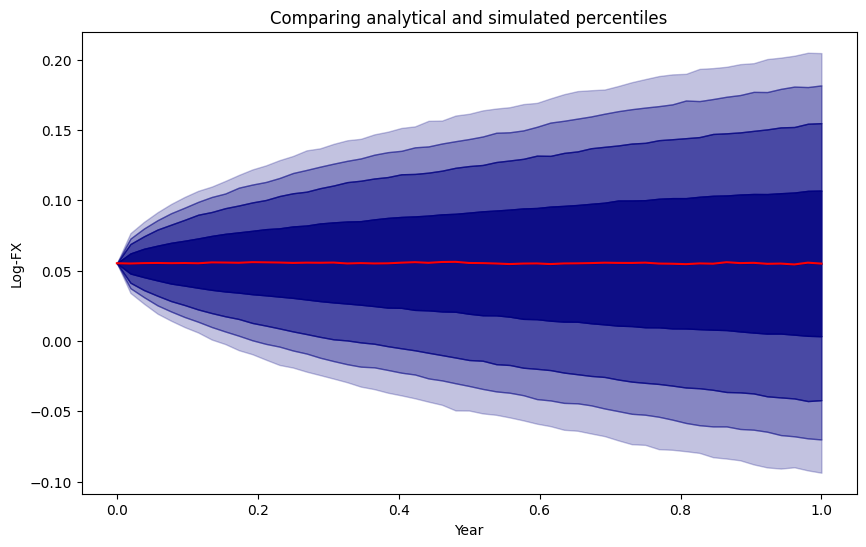

In [7]:
# calculate simulated percentiles for log-fx
percentiles = np.percentile(sim_data['LOG_FX'], [2.5, 5, 10, 25, 50, 75, 90, 95, 97.5], axis=0)

fig, ax = plt.subplots(figsize=(10, 6))
fan_chart(time_points, percentiles, ax=ax, color="navy")

ax.set(ylabel="Log-FX", xlabel="Year", title="Comparing analytical and simulated percentiles"); 

### The distribution of US equity prices in local currency

The risk driver is specified as the logarithm of the equity value. Thus, we can simply take $\exp$ to obtain the equity price series. Since the log equity value is normally distributed, then the equity value / price has to be log-normally distributed.

In [8]:
"""
Simulate price evolution
"""
sim_data['TRI_US_EQ_LOCAL'] = np.exp(sim_data['LOG_US_EQ_LOCAL'])
sim_data['TRI_EUR_EQ'] = np.exp(sim_data['LOG_EUR_EQ'])
sim_data['FX'] = np.exp(sim_data['LOG_FX'])

In [9]:
"""
Joint distribution of risk drivers at horizon
"""

# mu parameter in normal distribution of X_1
mu_x = init_x + num_per * mu_delta_x 

# Sigma parameter in normal distribution of X_1
cov_mat_x = num_per * cov_mat_delta_x

# volatilities of X_1
vols_x = np.sqrt(np.diag(cov_mat_x))

In [10]:
"""
marginal distributions of US EQ LOCAL, EUR EQ, and FX
"""

marginal_dists = dict()

# Marginal distribution of US Equities measured in USD
marginal_dists['TRI_US_EQ_LOCAL'] = stats.lognorm(s=vols_x[us_eq_local_idx], 
                                                  scale=np.exp(mu_x[us_eq_local_idx]))

#stats.lognorm(s=vols_delta_x[us_eq_local_idx] * np.sqrt(num_per), 
#                                                   scale=np.exp(init_x[us_eq_local_idx] + mu_delta_x[us_eq_local_idx] * num_per))

# Marginal distribution of EUR Equities measured in EUR
marginal_dists['TRI_EUR_EQ'] = stats.lognorm(s=vols_x[eur_eq_idx], scale=np.exp(mu_x[eur_eq_idx]))

# Marginal distribution of FX
marginal_dists['FX'] = stats.lognorm(s=vols_x[fx_idx], scale=np.exp(mu_x[fx_idx])) 

In [11]:
"""
Check mean or standard deviation of the marginal distribution - not the input parameters mu or sigma
"""
marginal_dists['TRI_US_EQ_LOCAL'].std()

0.16269812390890837

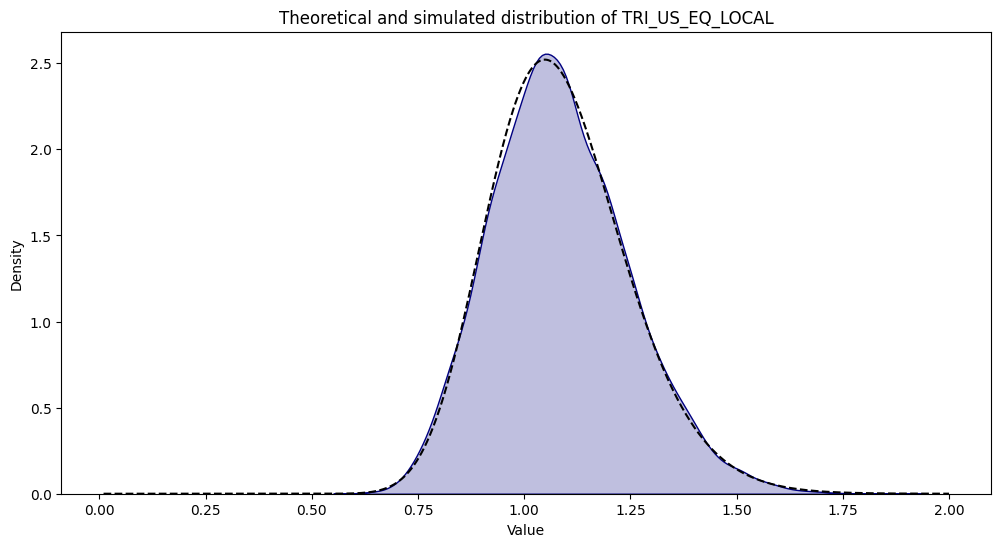

In [12]:
"""
Plot histogram and theoretical distribution
"""

# Define inputs
x_vals = np.linspace(0.01, 2.0, 1000)
name = "TRI_US_EQ_LOCAL"

# Plot figure
fig, ax = plt.subplots(figsize=(12, 6))

# Kernel density based on simulations
sns.kdeplot(sim_data[name][:, -1], fill=True, color="navy", ax=ax)

# True pdf 
ax.plot(x_vals, marginal_dists[name].pdf(x_vals), color="black", linestyle="--")

ax.set_xlabel('Value')
ax.set_title('Theoretical and simulated distribution of ' + name);

### The distribution of US bond prices in local currency

We can write the price of a zero coupon bond as 

$$
B_t^{t + \tau} = \exp(-y_{t}^{\tau} \cdot \tau)
$$

where $\tau$ is the time to maturity of the zero coupon bond. 

Since we define the whole yield curve with linear interpolation from the key rates, we can always write ($\mathbf{Y}_t$ is the vector of observed yields at time $t$)

$$
y_{t}^{\tau} = \mathbf{b}^\top \mathbf{Y}_t
$$

Since a linear combination of key rates also is normally distributed, then bond prices have to be log-normally distributed. 

In [13]:
"""
Define helper function
"""

def get_interpolation_weights(target_tenor: float, tenors: np.ndarray): 

    differences = np.abs(tenors - target_tenor)

    # Get the indices of the two closest values
    closest_indices = np.argsort(differences)[:2]
    
    # Sort the indices to ensure they are in ascending order
    closest_indices = np.sort(closest_indices)
    
    # Get the two closest values
    x1, x2 = tenors[closest_indices]
    
    # Calculate the interpolation weights
    w2 = (target_tenor - x1) / (x2 - x1)
    w1 = 1 - w2
    
    # Create a weights vector (all other weights are 0)
    weights = np.zeros_like(tenors, dtype=float)
    weights[closest_indices[0]] = w1
    weights[closest_indices[1]] = w2
    
    return weights

In [14]:
"""
Simulate evolution of bond prices
"""

sim_data['TRI_USD_ZCB_LOCAL'] = np.zeros_like(sim_data['LOG_FX'])
sim_data['TRI_EUR_ZCB'] = np.zeros_like(sim_data['LOG_FX'])

init_ttm = 5.0
sim_data['TRI_USD_ZCB_LOCAL'][:, 0] = np.exp(-init_ttm * sim_data['USD_RATE_5Y'][:, 0])
sim_data['TRI_EUR_ZCB'][:, 0] = np.exp(-init_ttm * sim_data['EUR_RATE_5Y'][:, 0])


for i in range(1, num_per + 1): 

    current_ttm = init_ttm - dt * i
    b_vec = get_interpolation_weights(current_ttm, tenors)

    sim_data['TRI_USD_ZCB_LOCAL'][:, i] = np.exp(-current_ttm * risk_drivers[:, i, usd_rates_idx] @ b_vec)
    sim_data['TRI_EUR_ZCB'][:, i] = np.exp(-current_ttm * risk_drivers[:, i, eur_rates_idx] @ b_vec)


In [15]:
"""
Specify analytical distribution at 1Y horizon of initial 5Y ZCB
"""


# specify distributional parameters
ttm_at_horizon = 4.0
b_vec = get_interpolation_weights(ttm_at_horizon, tenors)

# Marginal distribution of USD ZCB measured in USD
mu_usd_zcb = -b_vec @ mu_x[usd_rates_idx] * ttm_at_horizon
vol_usd_zcb = np.sqrt(b_vec @ cov_mat_x[np.array(usd_rates_idx)[:, None], usd_rates_idx] @ b_vec) * ttm_at_horizon
marginal_dists['TRI_USD_ZCB_LOCAL'] = stats.lognorm(s=vol_usd_zcb,
                                                    scale=np.exp(mu_usd_zcb))

# Marginal distribution of EUR ZCB measured in EUR
mu_eur_zcb =  -b_vec @ mu_x[eur_rates_idx] * ttm_at_horizon
vol_eur_zcb = np.sqrt(b_vec @ cov_mat_x[np.array(eur_rates_idx)[:, None], eur_rates_idx] @ b_vec) * ttm_at_horizon
marginal_dists['TRI_EUR_ZCB'] = stats.lognorm(s=vol_eur_zcb,
                                              scale=np.exp(mu_eur_zcb))

In [16]:
"""
USD parameters
"""

print('mu usd zcb: {:.3f}'.format(mu_usd_zcb))
print('vol usd zcb: {:.3f}'.format(vol_usd_zcb))

mu usd zcb: -0.151
vol usd zcb: 0.030


In [17]:
"""
EUR paramters
"""

print('mu eur zcb: {:.3f}'.format(mu_eur_zcb))
print('vol eur zcb: {:.3f}'.format(vol_eur_zcb))

mu eur zcb: -0.080
vol eur zcb: 0.024


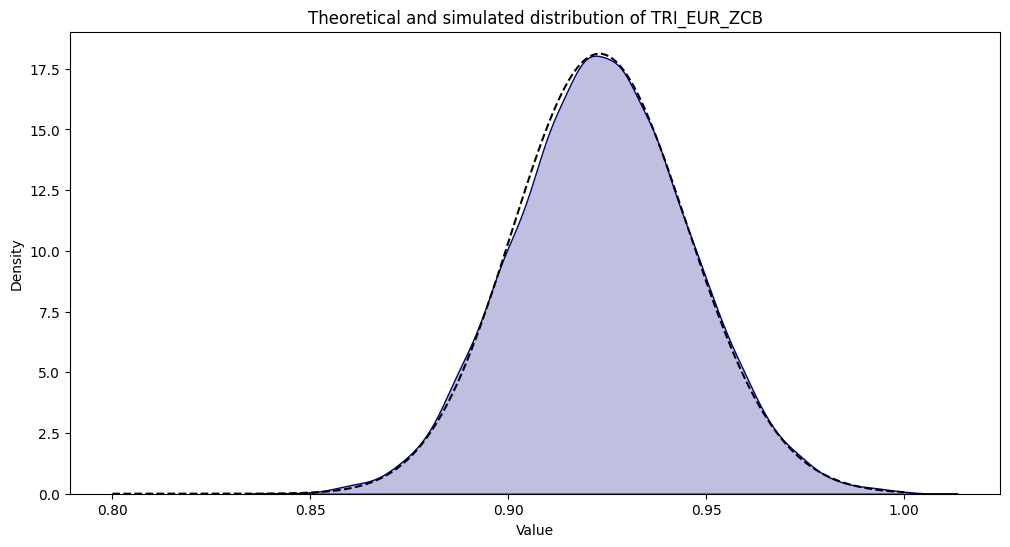

In [18]:
"""
Compare simulated and analytical distribution at 1Y horizon
"""

# Define inputs
vals_to_eval = np.linspace(0.8, 1.0, 1000)
name = 'TRI_EUR_ZCB'

# Plot figure
fig, ax = plt.subplots(figsize=(12, 6))

# Kernel density based on simulations
sns.kdeplot(sim_data[name][:, -1], fill=True, color="navy", ax=ax)

# True pdf 
ax.plot(vals_to_eval, marginal_dists[name].pdf(vals_to_eval), color="black", linestyle="--");

ax.set_xlabel('Value')
ax.set_title('Theoretical and simulated distribution of ' + name);

### The distribution of asset prices in local currency

We are able to write all the assets as an exponential affine expression of the risk drivers, see arguments above. 

$$
\mathbf{P}_{t + \Delta t \cdot N} = \exp(\mathbf{a} + \mathbf{B} \mathbf{X}_{t + \Delta t \cdot N} )
$$

This implies that the price vector is log-normally distributed

$$
\mathbf{P}_{t + \Delta t \cdot N} \sim \log N(\mathbf{a} + \mathbf{B} \boldsymbol{\mu}_1, \mathbf{B} \boldsymbol{\Sigma}_1 \mathbf{B}^\top)
$$

In [19]:
"""
Define multivariate distributional parameters for all assets in local currency at the horizon

Note: The vector a is zero in my calculations, but could include the initial values if done in slightly different way

"""

b_mat = np.zeros((5, len(mu_x)))

# No transformation of FX and equities
b_mat[0, fx_idx] = 1.0
b_mat[1, us_eq_local_idx] = 1.0
b_mat[2, eur_eq_idx] = 1.0

# ZCBs will have the interpolation vector in the B-matrix
ttm_at_horizon = 4.0
b_vec = get_interpolation_weights(ttm_at_horizon, tenors)

b_mat[3, usd_rates_idx] = -ttm_at_horizon * b_vec
b_mat[4, eur_rates_idx] = -ttm_at_horizon * b_vec

# Parameters in the log-normal distribution of prices in respective currencies
cov_mat_p_local = b_mat @ cov_mat_x @ b_mat.T
mu_p_local = b_mat @ mu_x

In [20]:
"""
B matrix
"""

pd.DataFrame(data=b_mat, columns=risk_driver_names, index=plot_names_local)

,log FX,log US EQ,log EUR EQ,1M EUR,1Y EUR,3Y EUR,5Y EUR,7Y EUR,10Y EUR,1M USD,1Y USD,3Y USD,5Y USD,7Y USD,10Y USD
FX,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
US EQ Local,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
EUR EQ,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
USD ZCB Local,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-2.0,-2.0,-0.0,-0.0
EUR ZCB,0.0,0.0,0.0,-0.0,-0.0,-2.0,-2.0,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
"""
Mu log-normal parameter
"""

'\nMu log-normal parameter\n'

In [22]:
pd.Series(mu_p_local, index=plot_names_local)

FX               0.055293
US EQ Local      0.070000
EUR EQ           0.060000
USD ZCB Local   -0.151230
EUR ZCB         -0.079519
dtype: float64

In [23]:
"""
Sigma log-normal parameter
"""

pd.DataFrame(data=cov_mat_p_local, columns=plot_names_local, index=plot_names_local).round(5)

,FX,US EQ Local,EUR EQ,USD ZCB Local,EUR ZCB
FX,0.00586,0.00200,-0.00024,0.00064,0.00008
US EQ Local,0.00200,0.02226,0.01747,-0.00040,0.00064
EUR EQ,-0.00024,0.01747,0.02420,-0.00075,0.00036
USD ZCB Local,0.00064,-0.00040,-0.00075,0.00092,0.00051
EUR ZCB,0.00008,0.00064,0.00036,0.00051,0.00057


Let $\boldsymbol{\mu}_{local} = \mathbf{a} + \mathbf{B} \boldsymbol{\mu}_1$ and $\boldsymbol{\Sigma}_{local} = \mathbf{B} \boldsymbol{\Sigma}_1 \mathbf{B}^\top$, then 

$$
\text{E}[\mathbf{P}_1] = e^{\boldsymbol{\mu}_{local}  + \frac{1}{2}\text{diag}(\boldsymbol{\Sigma}_{local})}
$$

and 

$$
\text{Cov}[\mathbf{P}_1] =  \text{E}[\mathbf{P}_1] \text{E}[\mathbf{P}_1]^\top \odot \left(e^{\boldsymbol{\Sigma}_{local}} - \mathbf{1} \right)
$$

In [24]:
"""
E[P_1]
"""

'\nE[P_1]\n'

In [25]:
pd.DataFrame(mom.calculate_log_norm_mean(mu_p_local, cov_mat_p_local), index=plot_names_local)

,0
FX,1.059954
US EQ Local,1.084510
EUR EQ,1.074765
USD ZCB Local,0.860045
EUR ZCB,0.923823


In [26]:
"""
Cov[P_1]
"""

pd.DataFrame(mom.calculate_log_norm_cov_mat(mu_p_local, cov_mat_p_local), columns=plot_names_local, index=plot_names_local).round(5)

,FX,US EQ Local,EUR EQ,USD ZCB Local,EUR ZCB
FX,0.00661,0.00230,-0.00028,0.00058,0.00008
US EQ Local,0.00230,0.02647,0.02055,-0.00037,0.00064
EUR EQ,-0.00028,0.02055,0.02830,-0.00069,0.00036
USD ZCB Local,0.00058,-0.00037,-0.00069,0.00068,0.00040
EUR ZCB,0.00008,0.00064,0.00036,0.00040,0.00049


### The distribution of asset prices in EUR

The price of a USD denominated asset will have a value denominated in EUR given by

$$
P_t^{EUR} = \frac{1}{FX_t} \cdot P_t^{USD}
$$

The product of two log-normal variables will also follow a log-normal distribution!

In [27]:
"""
Simulate evolution of prices in EUR
"""

sim_data['TRI_US_EQ'] = sim_data['TRI_US_EQ_LOCAL'] / sim_data['FX']
sim_data['TRI_USD_ZCB'] = sim_data['TRI_USD_ZCB_LOCAL'] / sim_data['FX']
sim_data['FX_INV'] = 1.0 / sim_data['FX']

We can apply a similar transformation as above

$$
\mathbf{P}_{t + \Delta t \cdot N}^{EUR} \sim \log N(\mathbf{W} \boldsymbol{\mu}_{local}, \mathbf{W} \boldsymbol{\Sigma}_{local} \mathbf{W}^\top)
$$

In [28]:
"""
Define weight matrix
"""
w_mat = np.zeros((5, 5))
w_mat[0, fx_idx] = -1.0
w_mat[us_eq_local_idx, fx_idx] = -1.0
w_mat[us_eq_local_idx, us_eq_local_idx] = 1.0
w_mat[eur_eq_idx, eur_eq_idx] = 1.0
w_mat[usd_zcb_idx, fx_idx] = -1.0
w_mat[usd_zcb_idx, usd_zcb_idx] = 1.0
w_mat[eur_zcb_idx, eur_zcb_idx] = 1.0

In [29]:
"""
W mat
"""

pd.DataFrame(data=w_mat, columns=plot_names_local, index=plot_names_eur)

,FX,US EQ Local,EUR EQ,USD ZCB Local,EUR ZCB
1 / FX,-1.0,0.0,0.0,0.0,0.0
US EQ,-1.0,1.0,0.0,0.0,0.0
EUR EQ,0.0,0.0,1.0,0.0,0.0
USD ZCB,-1.0,0.0,0.0,1.0,0.0
EUR ZCB,0.0,0.0,0.0,0.0,1.0


In [30]:
"""
Calculate parameter values
"""

cov_mat_p = w_mat @ cov_mat_p_local @ w_mat.T
vols_p = np.sqrt(np.diag(cov_mat_p))
mu_p = w_mat @ mu_p_local

In [31]:
"""
Mu log-normal parameter
"""

pd.DataFrame(mu_p, index=plot_names_eur)

,0
1 / FX,-0.055293
US EQ,0.014707
EUR EQ,0.060000
USD ZCB,-0.206523
EUR ZCB,-0.079519


In [32]:
"""
Sigma log-normal parameter
"""

pd.DataFrame(data=cov_mat_p, columns=plot_names_eur, index=plot_names_eur).round(5)

,1 / FX,US EQ,EUR EQ,USD ZCB,EUR ZCB
1 / FX,0.00586,0.00387,0.00024,0.00522,-0.00008
US EQ,0.00387,0.02413,0.01772,0.00283,0.00056
EUR EQ,0.00024,0.01772,0.02420,-0.00050,0.00036
USD ZCB,0.00522,0.00283,-0.00050,0.00551,0.00042
EUR ZCB,-0.00008,0.00056,0.00036,0.00042,0.00057


Let $\boldsymbol{\mu}_{eur} = \mathbf{W} \boldsymbol{\mu}_{local}$ and $\boldsymbol{\Sigma}_{eur} = \mathbf{W} \boldsymbol{\Sigma}_{local} \mathbf{W}^\top$, then 

$$
\text{E}[\mathbf{P}_1^{EUR}] = e^{\boldsymbol{\mu}_{eur}  + \frac{1}{2}\text{diag}(\boldsymbol{\Sigma}_{eur})}
$$

and 

$$
\text{Cov}[\mathbf{P}_1^{EUR}] =  \text{E}[\mathbf{P}_1^{EUR}] \text{E}[\mathbf{P}_1^{EUR}]^\top \odot \left(e^{\boldsymbol{\Sigma}_{eur}} - \mathbf{1} \right)
$$

In [33]:
"""
E[P_1^EUR]
"""

'\nE[P_1^EUR]\n'

In [34]:
pd.DataFrame(mom.calculate_log_norm_mean(mu_p, cov_mat_p), index=plot_names_eur)

,0
1 / FX,0.948987
US EQ,1.027131
EUR EQ,1.074765
USD ZCB,0.815650
EUR ZCB,0.923823


In [35]:
"""
Cov[P_1^EUR]
"""

pd.DataFrame(mom.calculate_log_norm_cov_mat(mu_p, cov_mat_p), columns=plot_names_eur, index=plot_names_eur).round(5)

,1 / FX,US EQ,EUR EQ,USD ZCB,EUR ZCB
1 / FX,0.00530,0.00378,0.00025,0.00405,-0.00007
US EQ,0.00378,0.02576,0.01973,0.00238,0.00053
EUR EQ,0.00025,0.01973,0.02830,-0.00044,0.00036
USD ZCB,0.00405,0.00238,-0.00044,0.00367,0.00032
EUR ZCB,-0.00007,0.00053,0.00036,0.00032,0.00049


In [36]:
"""
Marginal distributions
"""
# Marginal distribution of USD ZCB measured in EUR
marginal_dists['TRI_USD_ZCB'] = stats.lognorm(s=vols_p[usd_zcb_idx], scale=np.exp(mu_p[usd_zcb_idx]))

# Marginal distribution of US EQ measured in EUR
marginal_dists['TRI_US_EQ'] = stats.lognorm(s=vols_p[us_eq_idx], scale=np.exp(mu_p[us_eq_idx]))

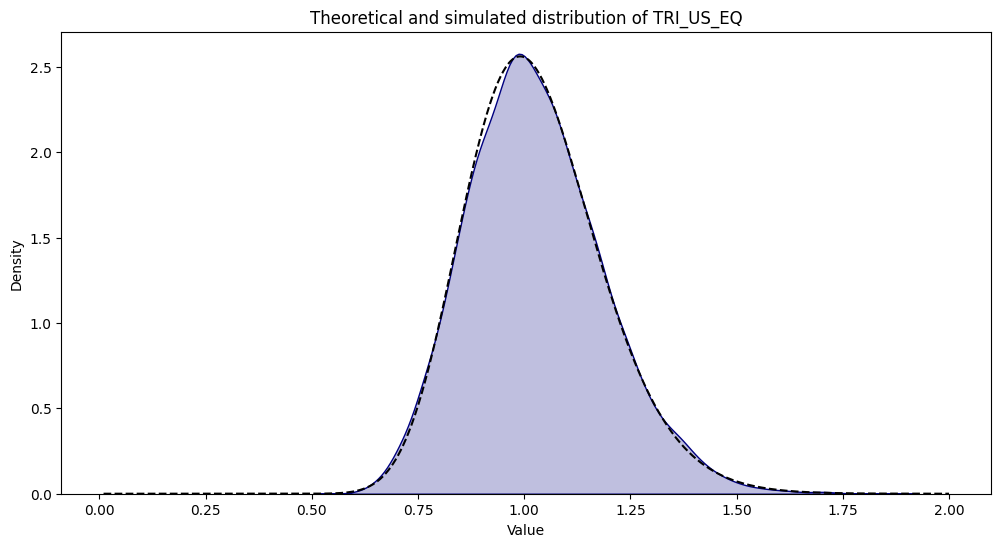

In [37]:
"""
Compare simulated and analytical distribution at 1Y horizon
"""

# Define inputs
vals_to_eval = np.linspace(0.01, 2.0, 1000)
name = 'TRI_US_EQ'

# Plot figure
fig, ax = plt.subplots(figsize=(12, 6))

# Kernel density based on simulations
sns.kdeplot(sim_data[name][:, -1], fill=True, color="navy", ax=ax)

# True pdf 
ax.plot(vals_to_eval, marginal_dists[name].pdf(vals_to_eval), color="black", linestyle="--")

ax.set_xlabel('Value')
ax.set_title('Theoretical and simulated distribution of ' + name);

### Calculate moments of EUR denominated assets

We simply use the rules for the multivariate log-normal distribution (see above)

In [38]:
cov_mat_p_l = mom.calculate_log_norm_cov_mat(mu_p, cov_mat_p)
vols_p_l = np.sqrt(np.diag(cov_mat_p_l))
mu_p_l = mom.calculate_log_norm_mean(mu_p, cov_mat_p)

### Price of a 1Y FX forward contract

The FX forward price is given by 

$$
F_{t, \tau} = FX_t e^{\tau (y_{t, \tau}^{USD} - y_{t, \tau}^{EUR})}
$$

In [39]:
init_fx = sim_data['FX'][0, 0] 
rf = sim_data['USD_RATE_1Y'][0, 0] 
rd = sim_data['EUR_RATE_1Y'][0, 0] 

fwd_price = init_fx * np.exp(rf - rd)
fwd_price

1.0773447966979737

### PnL and expected PnL

We can easily calculate the PnL and the moments since it is an affine transformation of $\mathbf{P}_1^{EUR}$, 

$$
\mathbf{PnL} = \mathbf{c} + \mathbf{D}\mathbf{P}_1^{EUR} 
$$

In [40]:
"""
Initial prices
"""
init_p = [0.0, sim_data['TRI_US_EQ'][0, 0], sim_data['TRI_EUR_EQ'][0, 0], sim_data['TRI_USD_ZCB'][0, 0], sim_data['TRI_EUR_ZCB'][0, 0]]

In [41]:
"""
Matrices for defining PnL
"""

const_vec_pnl = [1 / fwd_price , -sim_data['TRI_US_EQ'][0, 0], -sim_data['TRI_EUR_EQ'][0, 0], -sim_data['TRI_USD_ZCB'][0, 0], -sim_data['TRI_EUR_ZCB'][0, 0]]
pnl_mat = np.eye(5)
pnl_mat[0, 0] = -1

In [42]:
"""
Expected PnL
"""
mu_pnl = const_vec_pnl + pnl_mat @ mu_p_l

In [43]:
"""
E[PnL]
"""

pd.DataFrame(mu_pnl, index=asset_names)

,0
FX,-0.020779
TRI_US_EQ_LOCAL,0.080923
TRI_EUR_EQ,0.074765
TRI_USD_ZCB_LOCAL,0.030857
TRI_EUR_ZCB,0.019199


In [44]:
"""
Calculate PnL variance
"""

cov_mat_pnl = pnl_mat @ cov_mat_p_l @ pnl_mat.T
vol_pnl = np.sqrt(np.diag(cov_mat_pnl))

In [45]:
"""
Cov[PnL]
"""

pd.DataFrame(cov_mat_pnl, index=asset_names, columns=asset_names)

,FX,TRI_US_EQ_LOCAL,TRI_EUR_EQ,TRI_USD_ZCB_LOCAL,TRI_EUR_ZCB
FX,0.005297,-0.003776,-0.000250,-0.004055,0.000071
TRI_US_EQ_LOCAL,-0.003776,0.025762,0.019733,0.002376,0.000533
TRI_EUR_EQ,-0.000250,0.019733,0.028299,-0.000442,0.000355
TRI_USD_ZCB_LOCAL,-0.004055,0.002376,-0.000442,0.003673,0.000320
TRI_EUR_ZCB,0.000071,0.000533,0.000355,0.000320,0.000485


In [46]:
"""
Corr[PnL]
"""

pd.DataFrame(mom.cov_to_corr_matrix(cov_mat_pnl), index=asset_names, columns=asset_names)


,FX,TRI_US_EQ_LOCAL,TRI_EUR_EQ,TRI_USD_ZCB_LOCAL,TRI_EUR_ZCB
FX,1.000000,-0.323268,-0.020405,-0.919299,0.044553
TRI_US_EQ_LOCAL,-0.323268,1.000000,0.730852,0.244230,0.150708
TRI_EUR_EQ,-0.020405,0.730852,1.000000,-0.043399,0.095913
TRI_USD_ZCB_LOCAL,-0.919299,0.244230,-0.043399,1.000000,0.239827
TRI_EUR_ZCB,0.044553,0.150708,0.095913,0.239827,1.000000


The distribution of the PnL vector is closely linked to the log-normal distribution of the prices. For the cash assets the distribution follows a shifted log-normal. For the Forward contract, the distribution is not a log-normal distribution, but we can find the pdf since it is a simple linear transformation of a log-normal. 

We note that the PnL of the forward contract reads 

$$
\mathbf{PNL}_{1,1} = \frac{1}{F_0^1} - \frac{1}{FX_1}
$$

where we know that $\frac{1}{FX_1}$ is lognormal. Since, we can write 

$$
\frac{1}{FX_1} = \frac{1}{F_0^1}  - \mathbf{PNL}_{1,1}
$$

We will able to write the pdf pf the PnL as 

$$
f_{\mathbf{PNL}_{1,1}} (y) = f_{\frac{1}{FX_1}} (\frac{1}{F_0^1} - y) \cdot 1
$$

In [47]:
"""
Simulated PnL
"""

final_values = np.vstack([-sim_data['FX_INV'][:, -1], sim_data['TRI_US_EQ'][:, -1], sim_data['TRI_EUR_EQ'][:, -1],
           sim_data['TRI_USD_ZCB'][:, -1], sim_data['TRI_EUR_ZCB'][:, -1]])

final_pnl = final_values - np.r_[-1 / fwd_price, init_p[1:]][:, None]

In [48]:
"""
For PnL distribution
"""

class LogNormalTransformed(stats.rv_continuous):
    def __init__(self, mu, sigma, loc, scale):
        super().__init__(name="lognormal_transformed")
        self.mu = mu
        self.sigma = sigma
        self.loc = loc
        self.scale = scale

    def _pdf(self, y):
        # Compute the PDF of the transformed variable
        x = (self.loc - y) / self.scale
        #if x <= 0:
        #    return 0.0

        pdf_x = (1 / (x * np.sqrt(2 * np.pi) * self.sigma)) * \
                np.exp(-((np.log(x) - self.mu) ** 2) / (2 * self.sigma ** 2))
        
        jacobian = 1 / self.scale

        return pdf_x * jacobian

    def _cdf(self, y):
        from scipy.stats import lognorm

        # Ensure the domain restriction: y <= a
        if y > self.loc:
            return 1
        if y < self.loc - self.scale * np.exp(self.mu - 10 * self.sigma):  # Effectively 0 for practical purposes
            return 0

        x = (self.loc - y) / self.scale
        cdf_x = lognorm.cdf(x, s=self.sigma, scale=np.exp(self.mu))

        return 1 - cdf_x  # CDF flips due to the transformation

In [49]:
"""
Marginal distribution
"""
pnl_data = dict()

# Marginal distribution for PnL of forward contract
pnl_data['PNL_FX_FORWARD'] = final_pnl[fx_idx, :]
marginal_dists['PNL_FX_FORWARD'] = LogNormalTransformed(mu=mu_p[fx_idx], sigma=vols_p[fx_idx], loc=1 / fwd_price, scale=1)

# Marginal distribution for PnL of USD ZCP
pnl_data['PNL_USD_ZCB'] = final_pnl[usd_zcb_idx, :]
marginal_dists['PNL_USD_ZCB'] = stats.lognorm(s=vols_p[usd_zcb_idx], scale=np.exp(mu_p[usd_zcb_idx]), loc=const_vec_pnl[usd_zcb_idx])

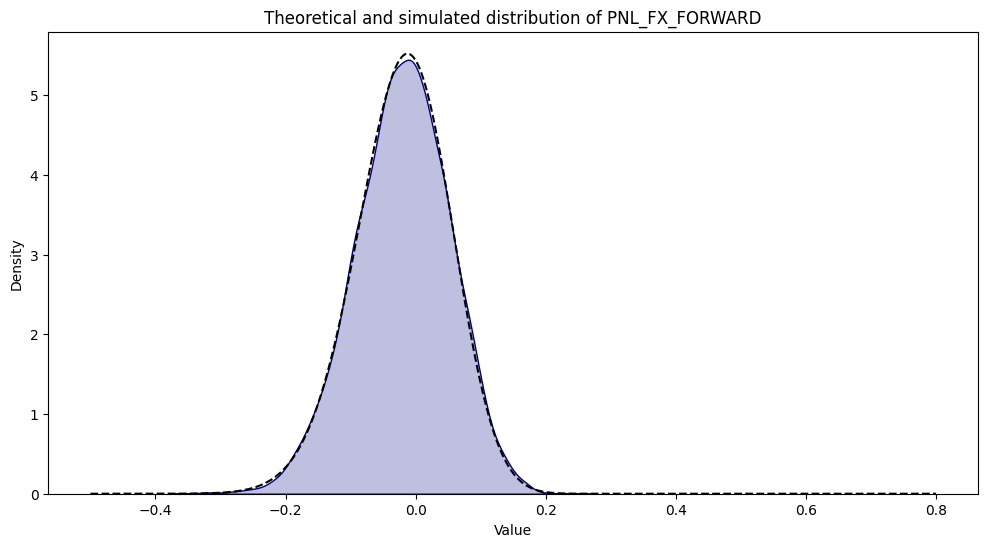

In [50]:
"""
Compare simulated and analytical distribution at 1Y horizon
"""

# Define inputs
vals_to_eval = np.linspace(-0.5, 0.8, 1000)
name = 'PNL_FX_FORWARD'

# Plot figure
fig, ax = plt.subplots(figsize=(12, 6))

# Kernel density based on simulations
sns.kdeplot(pnl_data[name], fill=True, color="navy", ax=ax)

# True pdf 
ax.plot(vals_to_eval, marginal_dists[name].pdf(vals_to_eval), color="black", linestyle="--")

ax.set_xlabel('Value')
ax.set_title('Theoretical and simulated distribution of ' + name);

### Portfolio PnL

The portfolio $PnL_1 = \mathbf{h}^\top \mathbf{PnL}_1$ has the expectation and variance 

$$
E[PnL_1] = \mathbf{h}^\top E[\mathbf{PnL}_1]
$$

and 

$$
Var[PnL_1] = \mathbf{h}^\top Cov[\mathbf{PnL}_1]\mathbf{h}
$$

The distribution of the portfolio does not follow a simply analytical distribution. 

## Hedging

The initial optimization problem reads 

$$
\min \mathbf{h}^\top \Sigma^{PNL} \mathbf{h} = \min h_1^2 \Sigma^{PNL}_{11}  + \mathbf{h}_2^\top \Sigma_{22}^{PNL} \mathbf{h}_2 + 2 h_1 \Sigma_{12}^{PNL} \mathbf{h}_2 
$$

subject to the constraint of the form

$$
\mathbf{A} \mathbf{h} = \mathbf{b}
$$

The contraint basically defines the allocation to the cash assets. 

It is important to note that one unit of an asset do not correspond to investing one EUR as the vector of prices are not all equal to one. Our allocations have to satisfy 

$$
(\mathbf{p}_0^{EUR})^\top \mathbf{h} = 1
$$

Given a constant allocation, we can find the optimal number of forward contracts as (take the derivative of the portfolio PnL variance wrt. $h_1$ and solve for $h_1$)

$$
\frac{\partial }{\partial h_1} h_1^2 \Sigma^{PNL}_{11}  + \mathbf{h}_2^\top \Sigma_{22}^{PNL} \mathbf{h}_2 + 2 h_1 \Sigma_{12}^{PNL} \mathbf{h}_2  = 2h_1\Sigma^{PNL}_{11} + 2  \Sigma_{12}^{PNL} \mathbf{h}_2 = 0
$$

Thus, 

$$
h_1^* = -\frac{\Sigma_{12}^{PNL} \mathbf{h}_2}{\Sigma^{PNL}_{11}}
$$

In [51]:
"""
Define function to calculate optimal hedge ratio given a fixed allocation
"""

def calculate_min_var_hedge_ratio(cov_mat: np.ndarray, cash_asset_holdings: np.ndarray):

    opt_fx_alloc = -cov_mat[0, 1:] @ cash_asset_holdings / cov_mat[0, 0]
    
    return opt_fx_alloc

### Hedging individual assets

We seek to explore the optimal hedging strategies for the individual US denominated assets and a portfolio. 

If we are buying 1 EUR of USD denominated assets, we will have a USD exposure of $FX_0 > 1$ initially. We need to take this into account, when plotting the hedge ratios. 

#### US Equities

Since the price of US equities is smaller than one, we have to by more than one unit of US equities, namely $1 / p_0^{USD \; EQ}$ units. 

In [52]:
hedge_ratios = np.arange(-1.0, 1.51, 0.1) 

# Only hedge US equities
h_us_eq = np.array([np.array([hr * init_fx, 1 / init_p[us_eq_idx], 0, 0, 0]) for hr in hedge_ratios])

mu_us_eq_hedged_pnl = h_us_eq @ mu_pnl
sigma2_us_eq_hedged_pnl = np.apply_along_axis(lambda x: x @ cov_mat_pnl @ x, 1, h_us_eq)
sigma_us_eq_hedged_pnl = np.sqrt(sigma2_us_eq_hedged_pnl)

In [53]:
"""
Optimal hedge ratio
"""

h1_min_var_us_eq = calculate_min_var_hedge_ratio(cov_mat_pnl, np.array([1 / init_p[us_eq_idx], 0, 0, 0])) #<- optimal h1
hr_min_var_us_eq = h1_min_var_us_eq / init_fx  #<- divide with USD exposure to get hedge ratio

h_min_var_us_eq = np.array([h1_min_var_us_eq, 1 / init_p[us_eq_idx], 0, 0, 0])
mu_min_var_us_eq_hedged_pnl = h_min_var_us_eq @ mu_pnl
sigma2_min_var_us_eq_hedged_pnl = h_min_var_us_eq @ cov_mat_pnl @ h_min_var_us_eq
sigma_min_var_us_eq_hedged_pnl = np.sqrt(sigma2_min_var_us_eq_hedged_pnl)

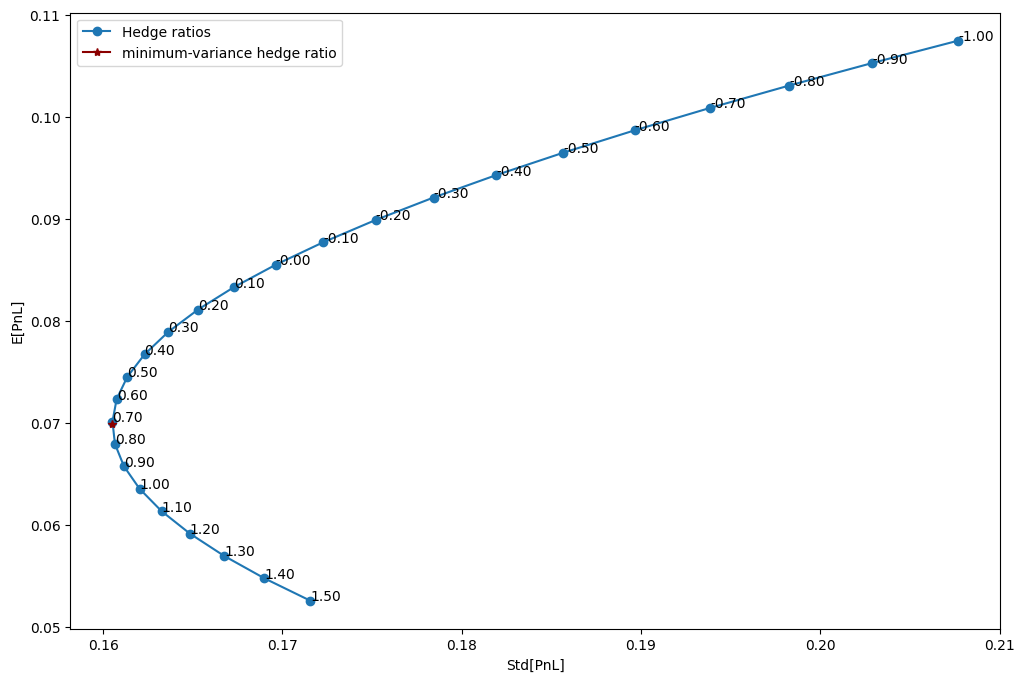

In [54]:
"""
Plot results
"""

fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(sigma_us_eq_hedged_pnl, mu_us_eq_hedged_pnl, marker="o", label="Hedge ratios")
ax.plot(sigma_min_var_us_eq_hedged_pnl, mu_min_var_us_eq_hedged_pnl, color="darkred", marker="*", label="minimum-variance hedge ratio")

for s,m,h in zip(sigma_us_eq_hedged_pnl, mu_us_eq_hedged_pnl, hedge_ratios): 
    ax.annotate("{:.2f}".format(h), (s, m))

ax.set(xlabel='Std[PnL]', ylabel="E[PnL]")

ax.legend();

#### US ZCB

In [55]:
# Only hedge USD ZCP
h_usd_zcb = np.array([np.array([hr * init_fx, 0, 0, 1 / init_p[usd_zcb_idx], 0]) for hr in hedge_ratios])
mu_usd_zcb_hedged_pnl = h_usd_zcb @ mu_pnl
sigma2_usd_zcb_hedged_pnl = np.apply_along_axis(lambda x: x @ cov_mat_pnl @ x, 1, h_usd_zcb)
sigma_usd_zcb_hedged_pnl = np.sqrt(sigma2_usd_zcb_hedged_pnl)

In [56]:
"""
Optimal hedge ratio
"""

h1_min_var_usd_zcb = calculate_min_var_hedge_ratio(cov_mat_pnl, np.array([0, 0, 1 / init_p[usd_zcb_idx], 0]))
hr_min_var_usd_zcb = h1_min_var_usd_zcb / init_fx

h_min_var_usd_zcb = np.array([h1_min_var_usd_zcb, 0, 0, 1 / init_p[usd_zcb_idx], 0])
mu_min_var_usd_zcb_hedged_pnl = h_min_var_usd_zcb @ mu_pnl
sigma2_min_var_usd_zcb_hedged_pnl = h_min_var_usd_zcb @ cov_mat_pnl @ h_min_var_usd_zcb
sigma_min_var_usd_zcb_hedged_pnl = np.sqrt(sigma2_min_var_usd_zcb_hedged_pnl)

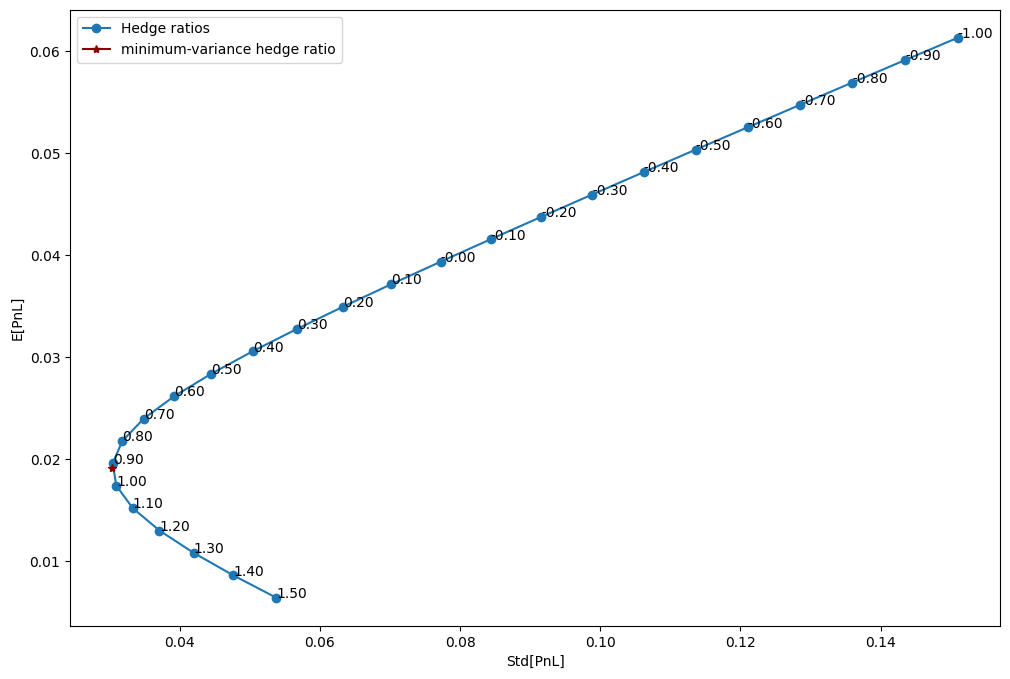

In [57]:
"""
Plot results
"""

fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(sigma_usd_zcb_hedged_pnl, mu_usd_zcb_hedged_pnl, marker="o", label="Hedge ratios")
ax.plot(sigma_min_var_usd_zcb_hedged_pnl, mu_min_var_usd_zcb_hedged_pnl, color="darkred", marker="*", label="minimum-variance hedge ratio")

for s,m,h in zip(sigma_usd_zcb_hedged_pnl, mu_usd_zcb_hedged_pnl, hedge_ratios): 
    ax.annotate("{:.2f}".format(h), (s, m))

ax.set(xlabel='Std[PnL]', ylabel="E[PnL]")
ax.legend();

### Hedging a portfolio

In [58]:
h_port_static = np.array([0.2 / init_p[us_eq_idx], 0.2, 0.3 / init_p[usd_zcb_idx], 0.3 / init_p[eur_zcb_idx]])

h_port = np.array([np.r_[hr * init_fx * 0.5, h_port_static] for hr in hedge_ratios])
mu_port_pnl = h_port @ mu_pnl
sigma2_port_pnl = np.apply_along_axis(lambda x: x @ cov_mat_pnl @ x, 1, h_port)
sigma_port_pnl = np.sqrt(sigma2_port_pnl)

In [59]:
"""
Optimal min variance hedge ratio
"""

h1_min_var_port = calculate_min_var_hedge_ratio(cov_mat_pnl, h_port_static)
hr_min_var_port = h1_min_var_port / (init_fx * 0.5)

h_min_var_port = np.r_[h1_min_var_port, h_port_static]
mu_min_var_port_pnl = h_min_var_port @ mu_pnl
sigma2_min_var_port_pnl = h_min_var_port @ cov_mat_pnl @ h_min_var_port
sigma_min_var_port_pnl = np.sqrt(sigma2_min_var_port_pnl)

In [60]:
# initial prices are generally different from 1!
init_p

[0.0, 0.9462080711548468, 1.0, 0.7847926613648827, 0.9046234128748379]

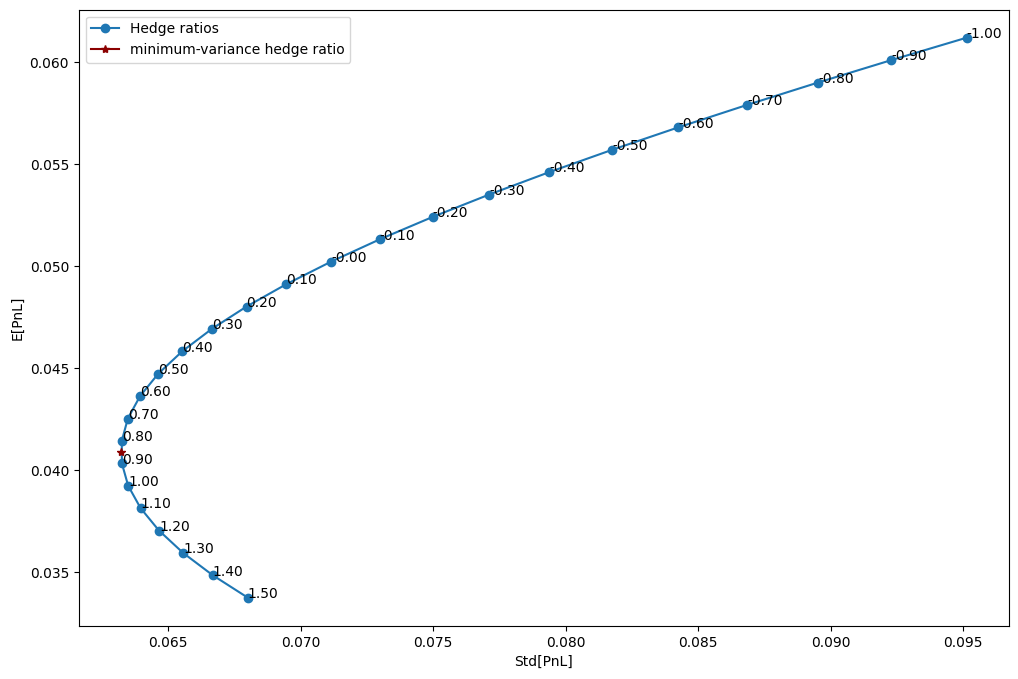

In [61]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(sigma_port_pnl, mu_port_pnl, marker="o", label="Hedge ratios")
ax.plot(sigma_min_var_port_pnl, mu_min_var_port_pnl, color="darkred",
        marker="*", label="minimum-variance hedge ratio")

for s,m,h in zip(sigma_port_pnl, mu_port_pnl, hedge_ratios): 
    ax.annotate("{:.2f}".format(h), (s, m))
    
ax.set(xlabel='Std[PnL]', ylabel="E[PnL]")
ax.legend();

In [62]:
"""
CVaR-mean figure
"""

cvar_port_pnl = np.apply_along_axis(lambda x: -rm.calculate_conditional_value_at_risk(x @ final_pnl, 0.05),
                                    1, h_port)

In [63]:
"""
Optimal min CVaR hedge ratio
"""

cvar_objective = lambda x: -rm.calculate_conditional_value_at_risk(x @ final_pnl, 0.05)

constraints = [{'type':'eq', 'fun': lambda x: x[1:] - h_port_static}]

res = optimize.minimize(cvar_objective, np.r_[0.0, h_port_static], constraints=constraints)

h_min_cvar_port = res.x
mu_min_cvar_port_pnl = h_min_cvar_port @ mu_pnl
sigma2_min_cvar_port_pnl = h_min_cvar_port @ cov_mat_pnl @ h_min_cvar_port
sigma_min_cvar_port_pnl = np.sqrt(sigma2_min_cvar_port_pnl)
cvar_min_cvar_port_pnl = cvar_objective(h_min_cvar_port)

In [64]:
# minimum CVaR
cvar_min_cvar_port_pnl

0.07412877966384487

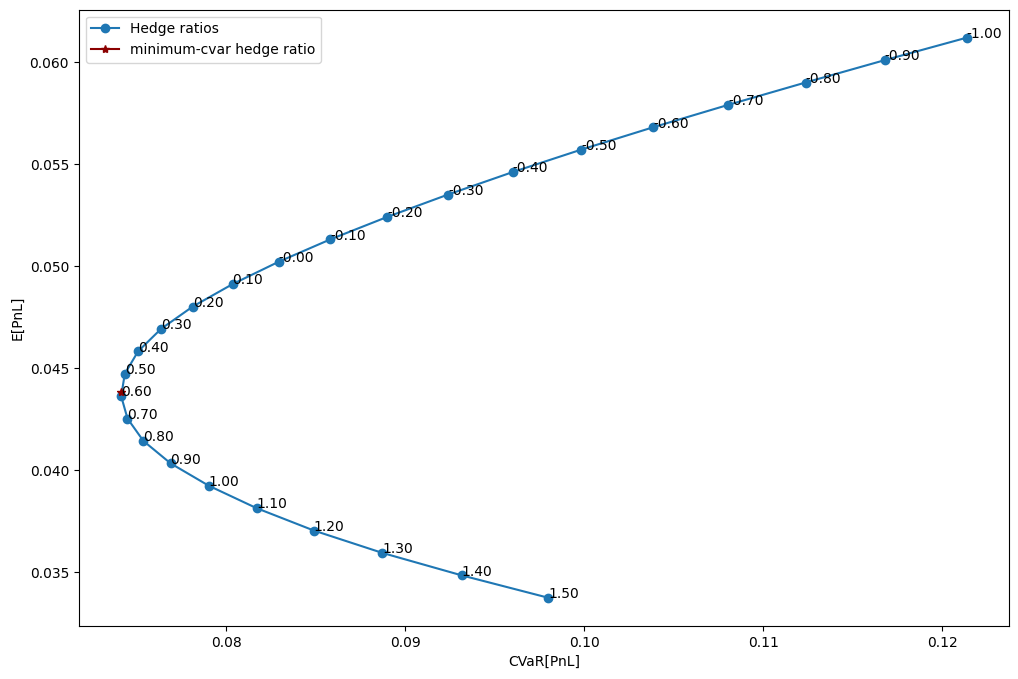

In [65]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(cvar_port_pnl, mu_port_pnl, marker="o", label="Hedge ratios")
ax.plot(cvar_min_cvar_port_pnl, mu_min_cvar_port_pnl, color="darkred",
        marker="*", label="minimum-cvar hedge ratio")

for s,m,h in zip(cvar_port_pnl, mu_port_pnl, hedge_ratios): 
    ax.annotate("{:.2f}".format(h), (s, m))


ax.set(xlabel='CVaR[PnL]', ylabel="E[PnL]")
ax.legend();

Generally, if the asset to be hedged is less risky, then we need a higher hedge ratio. The CVaR hedge ratio of the portfolio is much lower which is related to the large cost of hedging USD exposure since the CVaR is the average loss in the tail and not just the dispersion. 

In [66]:
pd.DataFrame([hr_min_var_us_eq, hr_min_var_usd_zcb, hr_min_var_port, h_min_cvar_port[0] / (0.5 * init_fx)], columns=['Hedge Ratio'], index=['US EQ', 'US ZCB', 'Port', 'Port CVaR'])

,Hedge Ratio
US EQ,0.712912
US ZCB,0.922942
Port,0.848316
Port CVaR,0.583749


### Simulation study of estimation uncertainty

The market invariants are normally distributed

$$
\Delta \mathbf{X}_t \sim N(\boldsymbol{\mu}, \boldsymbol{\Sigma})
$$

Thus, we can sample covariance matrices directly using the [Wishart distribution](https://en.wikipedia.org/wiki/Wishart_distribution). It is important to note that we do not loose a degree of freedom due to estimation of the mean as it is assumed to be known. 

After we have simulated a sample covariance matrix, we have to perform all the steps above to obtain the PnL expectation and covariance in order to find the minimum variance hedge for the portfolio. 

In [67]:
"""
Simulate weekly covariance matrices and mean vectors 
"""

# estimation sample size for sample mean and sample covariance matrix
sample_size = 52 * 2

# number of simulated sample covariance matrices (and sample means)
num_cov_sim = 100_000

# simulate sample covariance matrix  - change df to sample_size - 1 if mu is also estimated
sim_cov_mat_delta_x = stats.wishart.rvs(df = sample_size, scale = cov_mat_delta_x / sample_size, size = num_cov_sim)

# simulate sample mean - not doing this here
# sim_mu_hat = stats.multivariate_normal.rvs(mean=mu_delta_x, cov=cov_mat / sample_size, size = num_cov_sim)
sim_mu_delta_x = np.tile(mu_delta_x, (num_cov_sim, 1))

# propogate to investment horizon - log risk drivers
sim_cov_mat_x = num_per * sim_cov_mat_delta_x
sim_mu_x = init_x + num_per * sim_mu_delta_x 

# transform to prices 
sim_cov_mat_p_local = np.array([b_mat @ sim_cov_mat_x[i] @ b_mat.T for i in range(num_cov_sim)])
sim_mu_p_local = sim_mu_x @ b_mat.T

# transform to domestic currency 
sim_mu_p = sim_mu_p_local @ w_mat.T
sim_cov_mat_p = np.array([w_mat @ sim_cov_mat_p_local[i] @ w_mat.T for i in range(num_cov_sim)])

# transform to pnl covariance at horzion
sim_mu_l = np.array([mom.calculate_log_norm_mean(sim_mu_p[i], sim_cov_mat_p[i]) 
                             for i in range(num_cov_sim)])
                            
sim_cov_mat_l = np.array([mom.calculate_log_norm_cov_mat(sim_mu_p[i], sim_cov_mat_p[i]) 
                                  for i in range(num_cov_sim)])

# change sign of currency exposure 
sim_cov_mat_pnl = np.array([pnl_mat @ sim_cov_mat_l[i] @ pnl_mat.T for i in range(num_cov_sim)])

In [68]:
"""
Find minimum-variance hedge ratio
"""

opt_min_var_h1 = np.array([calculate_min_var_hedge_ratio(cov_mat=sim_cov_mat_pnl[i], 
                                                         cash_asset_holdings=np.array([0.2 / init_p[us_eq_idx], 0.2, 0.3 / init_p[usd_zcb_idx], 0.3 / init_p[eur_zcb_idx]]))
                          for i in range(num_cov_sim)])

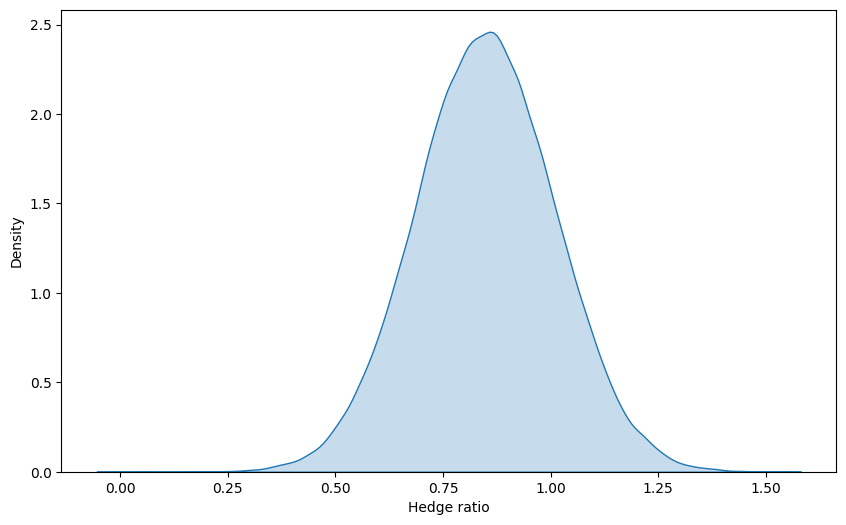

In [69]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.kdeplot(opt_min_var_h1 / (0.5 * init_fx), fill=True)

ax.set_xlabel(xlabel="Hedge ratio");

In [70]:
"""
Calculate the corresponding distribution of mean PnL, variance and conditional value at risk  
"""

sim_h_port = np.array([np.array([h1, 0.2 / init_p[us_eq_idx], 0.2, 0.3 / init_p[usd_zcb_idx], 0.3 / init_p[eur_zcb_idx]])  
                              for h1 in opt_min_var_h1])

sim_mu_port_pnl = sim_h_port @ mu_pnl
sim_sigma2_port_pnl = np.apply_along_axis(lambda x: x @ cov_mat_pnl @ x, 1, sim_h_port)
sim_sigma_port_pnl = np.sqrt(sim_sigma2_port_pnl)

sim_cvar_port_pnl = np.apply_along_axis(lambda x: -rm.calculate_conditional_value_at_risk(x @ final_pnl, 0.05), 1, sim_h_port)

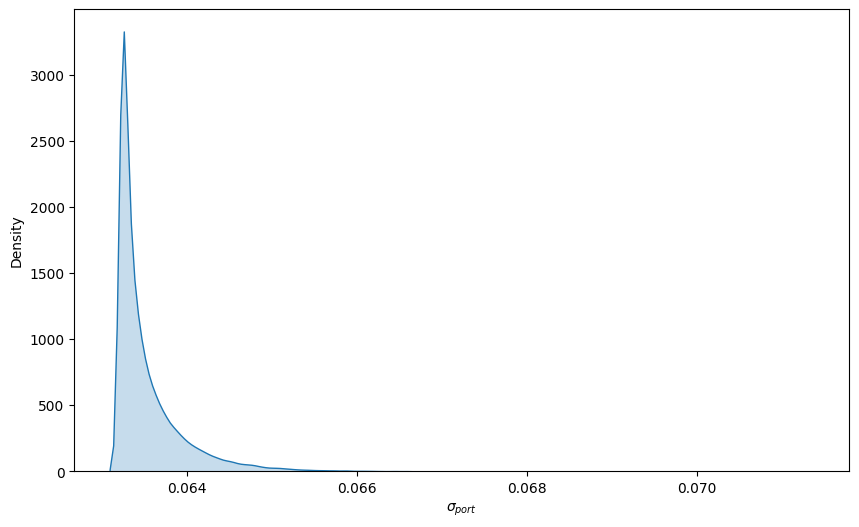

In [71]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.kdeplot(sim_sigma_port_pnl, fill=True)

ax.set_xlabel(xlabel="$\sigma_{port}$");

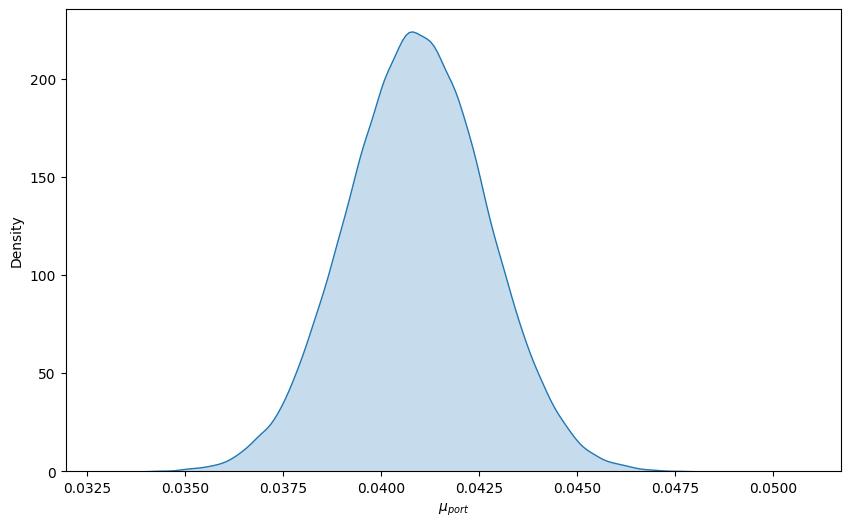

In [72]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.kdeplot(sim_mu_port_pnl, fill=True)

ax.set_xlabel(xlabel="$\mu_{port}$");

#cplt.number_format(ax.xaxis, pct=True)

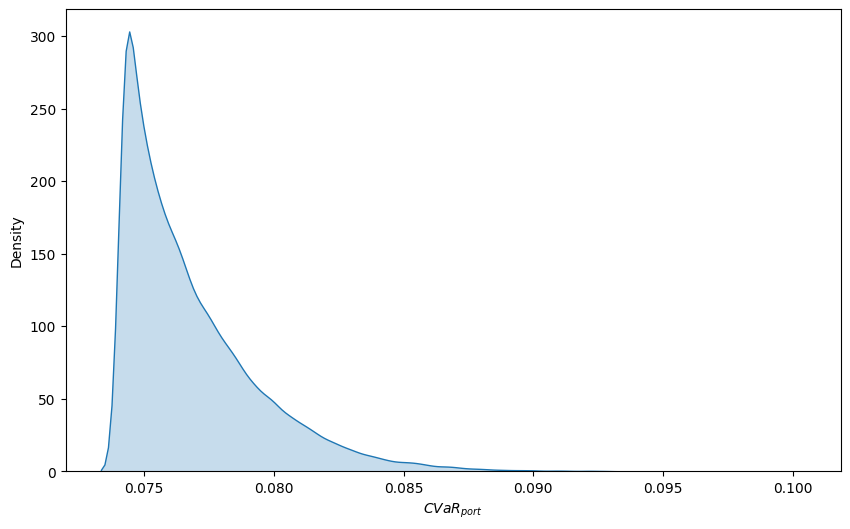

In [73]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.kdeplot(sim_cvar_port_pnl, fill=True)

ax.set_xlabel(xlabel="$CVaR_{port}$");

## Hedging as part of a portfolio optimization

### Portfolio optimization with prespecified hedge ratios

Our problem reads

$$
\min \mathbf{h}^\top \Sigma^{PNL} \mathbf{h} 
$$

subject to a budget constraint

$$
\mathbf{h}^\top (\mathbf{p}_0^{EUR}) = 1
$$

and a PnL target constraint

$$
\mathbf{h}^\top E[\mathbf{PNL}_1] = c
$$

and a no shorting constraint

$$
\mathbf{h}_2 > 0
$$

and fixing the hedge ratio as a predetermined levels obtained above

$$
h_1 = h_{2, 1} \cdot hr_{US \; EQ}^* \cdot p_0^{US \; EQ} * FX_0 + h_{2, 3} \cdot  hr_{USD \; ZCB}^* \cdot p_0^{USD \; ZCB} * FX_0
$$

In [74]:
# important to note that the prices are not all one!
init_p

[0.0, 0.9462080711548468, 1.0, 0.7847926613648827, 0.9046234128748379]

In [75]:
"""
Define problem for optimization
"""

# define optimization variable
h = cp.Variable(5)
pnl_target = cp.Parameter()
pnl_target.value = 0.05

# define constraints 
constraints = []
#constraints.append(h[0] == h[1] * hr_min_var_us_eq *  init_p[1] * init_fx  + h[3] * hr_min_var_usd_zcb * init_fx *  init_p[3] )
constraints.append(h[0] == h[1] * h1_min_var_us_eq *  init_p[1]  + 
                   h[3] * h1_min_var_usd_zcb *  init_p[3] )
constraints.append(h @ init_p == 1)
constraints.append(h[1:] >= 0)
constraints.append(h @ mu_pnl == pnl_target)
constraints.append(h[0] <= 2 * init_fx)
constraints.append(h[0] >= -2 * init_fx)

# define objective 
port_var = cp.Minimize(cp.QuadForm(h, cov_mat_pnl))

# define problem 
problem = cp.Problem(objective=port_var, constraints=constraints)

# solve problem 
result = problem.solve()

In [76]:
"""
Find min and max expected PnL
"""

constraints = []
#constraints.append(h[0] == h[1] * hr_min_var_us_eq *  init_p[1] * init_fx  + 
#                   h[3] * hr_min_var_usd_zcb *  init_p[3] * init_fx)
constraints.append(h[0] == h[1] * h1_min_var_us_eq *  init_p[1]  + 
                   h[3] * h1_min_var_usd_zcb *  init_p[3] )
constraints.append(h @ init_p == 1)
constraints.append(h[1:] >= 0)
constraints.append(h[0] <= 2 * init_fx)
constraints.append(h[0] >= -2 * init_fx)

# min PnL
problem_min_pnl = cp.Problem(cp.Minimize(h @  mu_pnl), constraints=constraints)
result = problem_min_pnl.solve()
min_pnl = h.value @ mu_pnl

# max PnL
problem_max_pnl = cp.Problem(cp.Maximize(h @  mu_pnl), constraints=constraints)
result = problem_max_pnl.solve()
print(h.value)
max_pnl = h.value @ mu_pnl

[1.91449201e-08 2.64295160e-08 9.99999975e-01 3.95821042e-10
 6.82822362e-11]


In [77]:
pnl_targets = np.linspace(min_pnl, max_pnl, 100)

h_opt_fixed_hedge_ratio = []

for t in pnl_targets: 

    pnl_target.value = t 

    result = problem.solve()

    h_opt_fixed_hedge_ratio.append(np.array(h.value))

h_opt_fixed_hedge_ratio = np.array(h_opt_fixed_hedge_ratio)


In [78]:
mu_opt_fixed_hedge_ratio = h_opt_fixed_hedge_ratio @ mu_pnl
sigma2_opt_fixed_hedge_ratio = np.apply_along_axis(lambda x: x @ cov_mat_pnl @ x, 1, h_opt_fixed_hedge_ratio)
sigma_opt_fixed_hedge_ratio = np.sqrt(sigma2_opt_fixed_hedge_ratio)

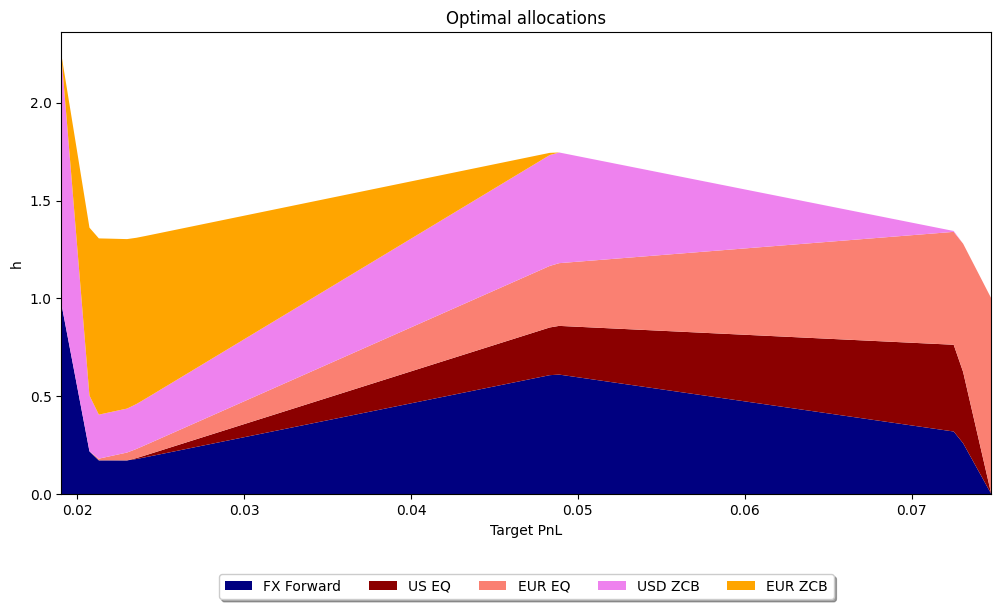

In [79]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.stackplot(pnl_targets, h_opt_fixed_hedge_ratio.T, labels=plot_names, colors=color_list)

ax.legend(loc='center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=6);
ax.set_xlabel("Target PnL")
ax.set_ylabel("h")
ax.set_title("Optimal allocations");
ax.set_xlim([min_pnl, max_pnl]);

The most risky portfolio is only holding EUR Equities because the high hedge ratio creates a drag on US equity PnL

In [80]:
h_opt_fixed_hedge_ratio[-1, :] @ mu_pnl

0.07476459405595114

### Portfolio optimization with unhedged assets and subsequent min-variance hedge ratio

We are know solving a two step problem. 

First, we solve the following problem to find $\mathbf{h}_2$

$$
\min \mathbf{h}^\top \Sigma^{PNL} \mathbf{h} 
$$

subject to a budget constraint

$$
\mathbf{h}^\top (\mathbf{p}_0^{EUR}) = 1
$$

and a PnL target constraint

$$
\mathbf{h}^\top E[\mathbf{PNL}_1] = c
$$

and a no shorting constraint

$$
\mathbf{h}_2 > 0
$$

and zero hedge ratio constraint

$$
h_1 = 0
$$

Secondly, we find 

$$
h_1^* = -\frac{\Sigma_{12}^{PNL} \mathbf{h}_2}{\Sigma^{PNL}_{11}}
$$

In [81]:
"""
Define problem for optimization
"""

# define optimization variable
h = cp.Variable(5)
pnl_target = cp.Parameter()
pnl_target.value = 0.05

# define constraints 
constraints = []
constraints.append(h @ init_p == 1)
constraints.append(h[1:] >= 0)
constraints.append(h @ mu_pnl == pnl_target)
constraints.append(h[0] == 0)

# define objective 
port_var = cp.Minimize(cp.QuadForm(h, cov_mat_pnl))

# define problem 
problem = cp.Problem(objective=port_var, constraints=constraints)

# solve problem 
result = problem.solve()

In [82]:
"""
Find min and max expected PnL
"""

constraints = []
constraints.append(h @ init_p == 1)
constraints.append(h[1:] >= 0)
constraints.append(h[0] == 0)

# min PnL
problem_min_pnl = cp.Problem(cp.Minimize(h @  mu_pnl), constraints=constraints)
result = problem_min_pnl.solve()
min_pnl = h.value @ mu_pnl

# max PnL
problem_max_pnl = cp.Problem(cp.Maximize(h @  mu_pnl), constraints=constraints)
result = problem_max_pnl.solve()
print(h.value)
max_pnl = h.value @ mu_pnl

[-4.21508443e-26  1.05685000e+00  3.41847851e-10  1.04770423e-09
  5.44106927e-10]


In [83]:
pnl_targets = np.linspace(min_pnl, max_pnl, 100)

h_opt_sub_hedge_ratio = []

for t in pnl_targets: 

    pnl_target.value = t 

    result = problem.solve()

    h_step_one = np.array(h.value)
    opt_hr = calculate_min_var_hedge_ratio(cov_mat_pnl, h_step_one[1:])
    h_step_one[0] = opt_hr
    
    h_opt_sub_hedge_ratio.append(h_step_one)

h_opt_sub_hedge_ratio = np.array(h_opt_sub_hedge_ratio)

In [84]:
mu_opt_sub_hedge_ratio = h_opt_sub_hedge_ratio @ mu_pnl
sigma2_opt_sub_hedge_ratio = np.apply_along_axis(lambda x: x @ cov_mat_pnl @ x, 1, h_opt_sub_hedge_ratio)
sigma_opt_sub_hedge_ratio = np.sqrt(sigma2_opt_sub_hedge_ratio)

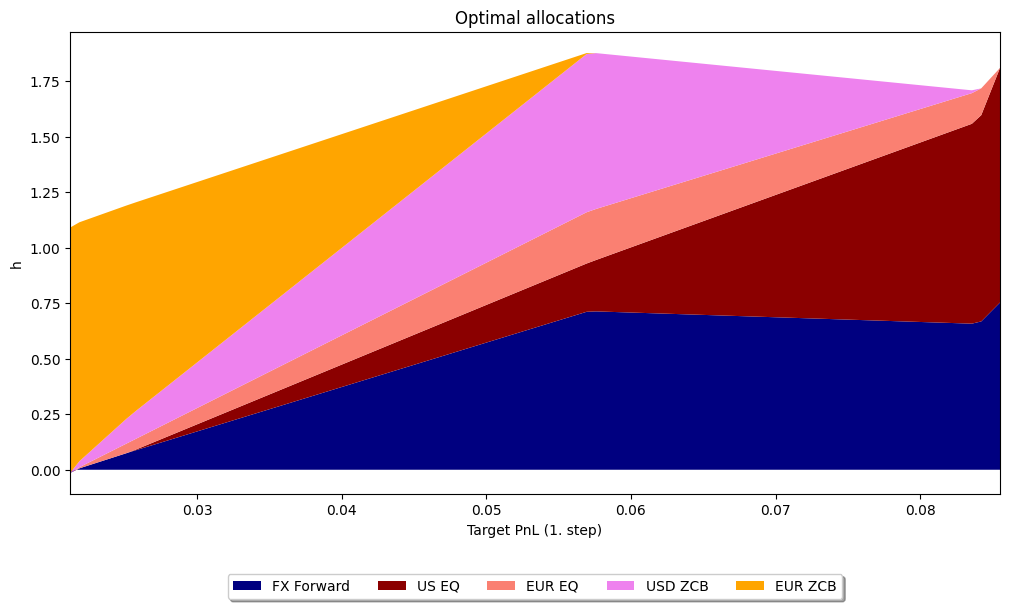

In [85]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.stackplot(pnl_targets, h_opt_sub_hedge_ratio.T, labels=plot_names, colors=color_list)

ax.legend(loc='center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=6);
ax.set_xlabel("Target PnL (1. step)")
ax.set_ylabel("h")
ax.set_title("Optimal allocations");
ax.set_xlim([min_pnl, max_pnl]);

The most risky portfolio is only holding US Equities because unhedged US equities have the highest return. However, we will not obtain the first step target return due to the drag for the hedge. 

In [86]:
# target pnl for the most risiky portfolio
pnl_targets[-1]

0.08552380439526543

In [87]:
# actual expected pnl
h_opt_sub_hedge_ratio[-1, :] @ mu_pnl

0.06986825256202016

### Portfolio optimization with hedge ratio as part of the portfolio optimization

Our problem reads

$$
\min \mathbf{h}^\top \Sigma^{PNL} \mathbf{h} 
$$

subject to a budget constraint

$$
\mathbf{h}^\top (\mathbf{p}_0^{EUR}) = 1
$$

and a PnL target constraint

$$
\mathbf{h}^\top E[\mathbf{PNL}_1] = c
$$

and a no shorting constraint

$$
\mathbf{h}_2 > 0
$$

In [88]:
"""
Define problem for optimization
"""

# define optimization variable
h = cp.Variable(5)
pnl_target = cp.Parameter()
pnl_target.value = 0.05

# define constraints 
constraints = []
constraints.append(h @ init_p == 1)
constraints.append(h[1:] >= 0)
constraints.append(h @ mu_pnl == pnl_target)
constraints.append(h[0] <= 2 * init_fx)
constraints.append(h[0] >= -2 * init_fx)

# define objective 
port_var = cp.Minimize(cp.QuadForm(h, cov_mat_pnl))

# define problem 
problem = cp.Problem(objective=port_var, constraints=constraints)

# solve problem 
result = problem.solve()

In [89]:
"""
Find min and max expected PnL
"""

constraints = []
constraints.append(h @ init_p == 1)
constraints.append(h[1:] >= 0)
constraints.append(h[0] <= 2 * init_fx)
constraints.append(h[0] >= -2 * init_fx)

# min PnL
problem_min_pnl = cp.Problem(cp.Minimize(h @  mu_pnl), constraints=constraints)
result = problem_min_pnl.solve()
min_pnl = h.value @ mu_pnl

# max PnL
problem_max_pnl = cp.Problem(cp.Maximize(h @  mu_pnl), constraints=constraints)
result = problem_max_pnl.solve()
print(h.value)
max_pnl = h.value @ mu_pnl

[-2.11369999e+00  1.05684998e+00  4.49858094e-09  9.13342454e-09
  6.22930779e-09]


In [90]:
pnl_targets = np.linspace(min_pnl, max_pnl, 100)

h_opt_free_hedge_ratio = []

for t in pnl_targets: 

    pnl_target.value = t 

    result = problem.solve()

    h_opt_free_hedge_ratio.append(np.array(h.value))

h_opt_free_hedge_ratio = np.array(h_opt_free_hedge_ratio)

In [91]:
mu_opt_free_hedge_ratio = h_opt_free_hedge_ratio @ mu_pnl
sigma2_opt_free_hedge_ratio = np.apply_along_axis(lambda x: x @ cov_mat_pnl @ x, 1, h_opt_free_hedge_ratio)
sigma_opt_free_hedge_ratio = np.sqrt(sigma2_opt_free_hedge_ratio)

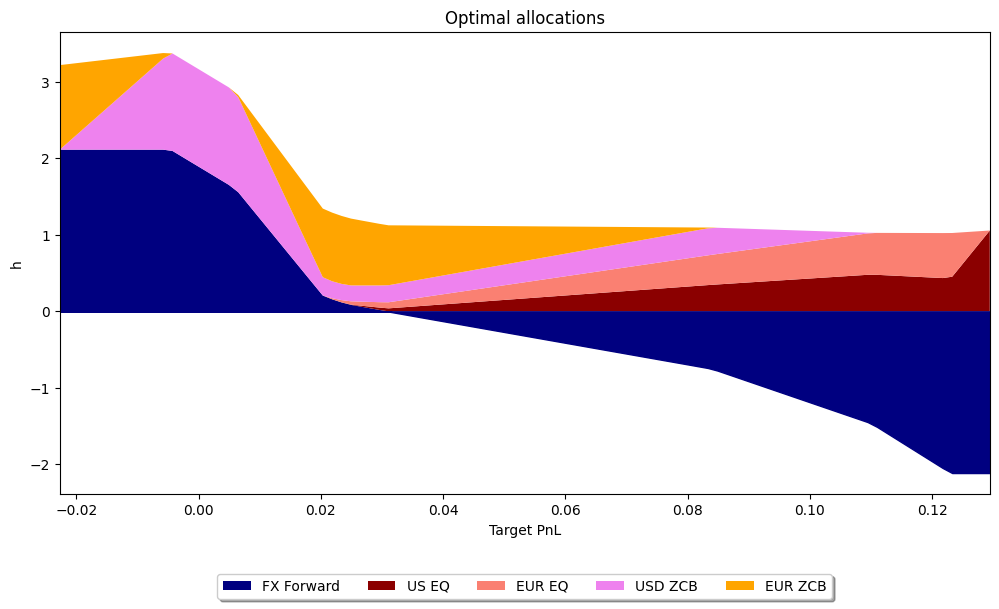

In [92]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.stackplot(pnl_targets, np.maximum(0, h_opt_free_hedge_ratio).T, labels=plot_names, colors=color_list)
ax.stackplot(pnl_targets, np.minimum(0, h_opt_free_hedge_ratio[:, 0]), color=color_list[0])

ax.legend(loc='center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=6);
ax.set_xlabel("Target PnL")
ax.set_ylabel("h")
ax.set_title("Optimal allocations")
ax.set_xlim([min_pnl, max_pnl]);

Since we have a negative expected PnL on the hedge, we can short it to increase the expected return. Therefore, the most risky and highest PnL portfolios have a large negative allocation to the hedge instrument while allocating fully to US equities. 

#### Comparison of efficient frontiers

In [93]:
print(vols_p[1:])
print(mu_p_l[1:])

[0.15532314 0.15557414 0.07419901 0.02384526]
[1.02713139 1.0747646  0.81564977 0.9238228 ]


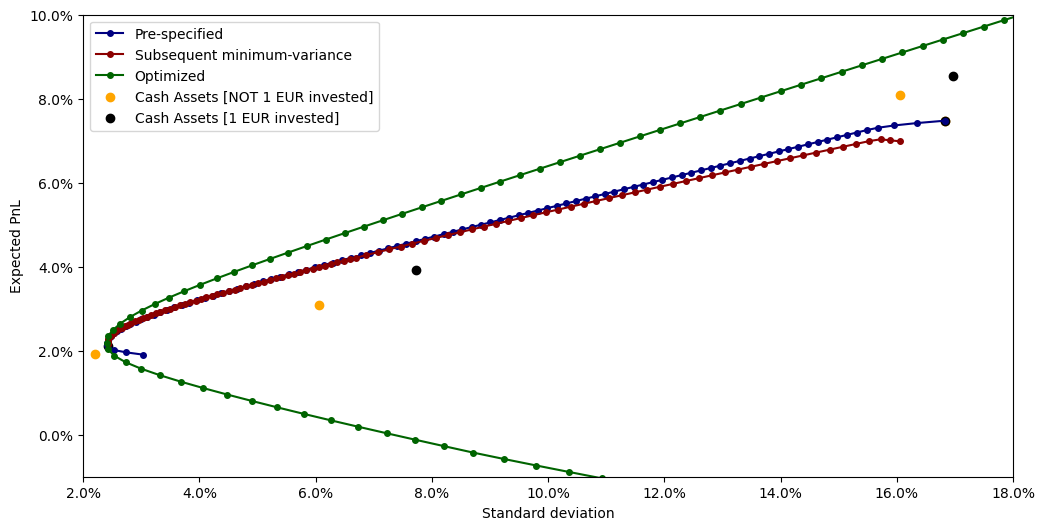

In [94]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(sigma_opt_fixed_hedge_ratio, mu_opt_fixed_hedge_ratio, marker="o", ms=4, color="navy", label="Pre-specified")
ax.plot(sigma_opt_sub_hedge_ratio, mu_opt_sub_hedge_ratio, marker="o", ms=4, color='darkred', label="Subsequent minimum-variance")
ax.plot(sigma_opt_free_hedge_ratio, mu_opt_free_hedge_ratio, marker="o", ms=4, color="darkgreen", label="Optimized")

ax.scatter(vol_pnl[1:], mu_pnl[1:], label='Cash Assets [NOT 1 EUR invested]', color="orange")
ax.scatter(vol_pnl[1:] * 1 / init_p[1:], mu_pnl[1:] * 1 / init_p[1:], label = 'Cash Assets [1 EUR invested]', color="black")

ax.legend()
ax.set_xlim([0.02, 0.18])
ax.set_ylim([-0.01, 0.10])

ax.xaxis.set_major_formatter(PercentFormatter(1))
ax.yaxis.set_major_formatter(PercentFormatter(1))

ax.set(ylabel='Expected PnL', xlabel="Standard deviation");

[Text(0, 0.5, 'Expected PnL'), Text(0.5, 0, 'Standard deviation')]

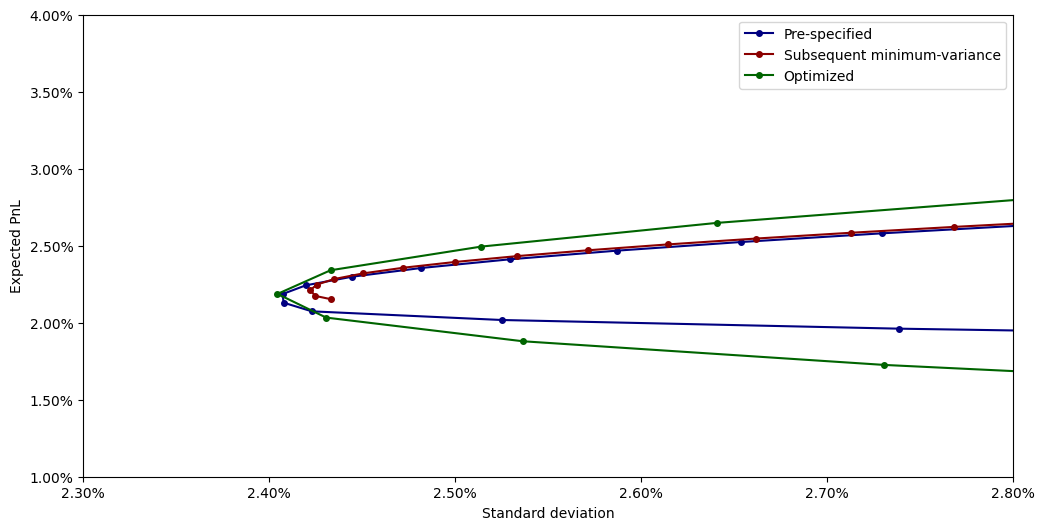

In [95]:
"""
Zoom
"""

fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(sigma_opt_fixed_hedge_ratio, mu_opt_fixed_hedge_ratio, marker="o", ms=4, color="navy", label="Pre-specified")
ax.plot(sigma_opt_sub_hedge_ratio, mu_opt_sub_hedge_ratio, marker="o", ms=4, color='darkred', label="Subsequent minimum-variance")
ax.plot(sigma_opt_free_hedge_ratio, mu_opt_free_hedge_ratio, marker="o", ms=4, color="darkgreen", label="Optimized")

ax.legend()
ax.set_xlim([0.023, 0.028])
ax.set_ylim([0.01, 0.04])

ax.xaxis.set_major_formatter(PercentFormatter(1))
ax.yaxis.set_major_formatter(PercentFormatter(1))

ax.set(ylabel='Expected PnL', xlabel="Standard deviation")

We will generally obtain the most efficient portfolios using the unconstrained approach. In the case of the minimum variance portfolio that primarily holds bonds, the difference is not large for the first and third approach. 

## Estimation uncertainty and efficient portfolios

We can reuse the simulated covariance matrices from above and examine the effect of estimation uncertainty. 

### Pre-specified

In [96]:
def calculate_portfolio_prespecified(mu_p, cov_mat_pnl, pnl_target=0.04): 

    mu_pnl = mu_p - init_p
    mu_pnl[0] = 1 / fwd_price - mu_pnl[0]
    
    """
    Define problem for optimization
    """
    
    # define optimization variable
    h = cp.Variable(5)

    hr_us_eq = calculate_min_var_hedge_ratio(cov_mat_pnl, np.array([1 / init_p[us_eq_idx], 0, 0, 0]))
    hr_usd_zcb = calculate_min_var_hedge_ratio(cov_mat_pnl, np.array([0, 0, 1 / init_p[usd_zcb_idx], 0]))

    #print(hr_us_eq)
    #print(hr_usd_zcb)
    
    # define constraints 
    constraints = []
    constraints.append(h[0] == h[1] * hr_us_eq *  init_p[1] * init_fx  + h[3] * hr_usd_zcb *  init_p[3] * init_fx)
    constraints.append(h @ init_p == 1)
    constraints.append(h[1:] >= 0)
    constraints.append(h @ mu_pnl >= pnl_target)
    constraints.append(h[0] <= 2 * init_fx)
    constraints.append(h[0] >= -2 * init_fx)
    
    # define objective 
    port_var = cp.Minimize(cp.QuadForm(h, cov_mat_pnl))
    
    # define problem 
    problem = cp.Problem(objective=port_var, constraints=constraints)
    
    # solve problem 
    result = problem.solve()
    #print(h.value)
    return np.array(h.value)

In [97]:
sim_opt_pre_h = np.array([calculate_portfolio_prespecified(mu_p=sim_mu_l[i], cov_mat_pnl=sim_cov_mat_pnl[i], pnl_target=0.04) for i in range(1000)])

### subsequent

In [98]:
def calculate_portfolio_w_subsequent_hedge(mu_p, cov_mat_pnl, pnl_target=0.04): 

    mu_pnl = mu_p - init_p
    mu_pnl[0] = 1 / fwd_price - mu_pnl[0]

    """
    Define problem for optimization
    """
    
    # define optimization variable
    h = cp.Variable(5)
    pnl_target = cp.Parameter()
    pnl_target.value = 0.05
    
    # define constraints 
    constraints = []
    constraints.append(h @ init_p == 1)
    constraints.append(h[1:] >= 0)
    constraints.append(h @ mu_pnl == pnl_target)
    constraints.append(h[0] == 0)
    
    # define objective 
    port_var = cp.Minimize(cp.QuadForm(h, cov_mat_pnl))
    
    # define problem 
    problem = cp.Problem(objective=port_var, constraints=constraints)
    
    # solve problem 
    result = problem.solve()

    # subsequent minimum-variance hedge 
    h_opt = np.array(h.value)
    opt_hr = calculate_min_var_hedge_ratio(cov_mat_pnl, h_opt[1:])
    h_opt[0] = opt_hr

    return h_opt

In [99]:
sim_opt_sub_h = np.array([calculate_portfolio_w_subsequent_hedge(mu_p=sim_mu_l[i],
                                                                 cov_mat_pnl=sim_cov_mat_pnl[i],
                                                                 pnl_target=0.04) for i in range(1000)])

### Full

In [100]:
def calculate_portfolio_full(mu_p, cov_mat_pnl, pnl_target=0.04): 

    mu_pnl = mu_p - init_p
    mu_pnl[0] = 1 / fwd_price - mu_pnl[0]
    
    """
    Define problem for optimization
    """
    
    h = cp.Variable(5)
    
    # define constraints 
    constraints = []
    constraints.append(h @ init_p == 1)
    constraints.append(h[1:] >= 0)
    constraints.append(h @ mu_pnl >= pnl_target)
    constraints.append(h[0] <= 2 * init_fx)
    constraints.append(h[0] >= -2 * init_fx)
    
    # define objective 
    port_var = cp.Minimize(cp.QuadForm(h, cov_mat_pnl))
    
    # define problem 
    problem = cp.Problem(objective=port_var, constraints=constraints)
    
    # solve problem 
    result = problem.solve()

    return np.array(h.value)

In [101]:
sim_opt_full_h = np.array([calculate_portfolio_full(mu_p=sim_mu_l[i], cov_mat_pnl=sim_cov_mat_pnl[i], pnl_target=0.04) for i in range(1000)])

In [102]:
sim_opt_full_h.shape

(1000, 5)

### Comparison

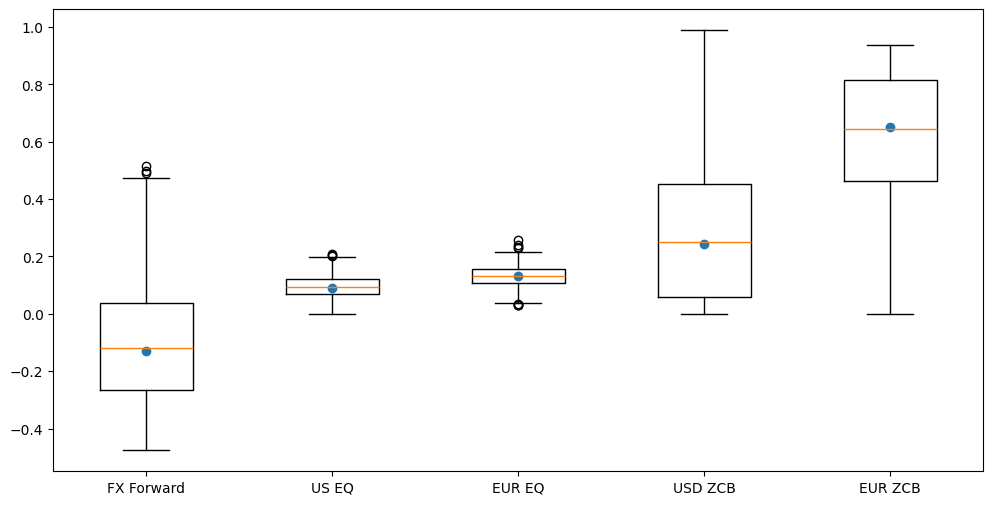

In [103]:
opt_full_h_true = calculate_portfolio_full(mu_p=mu_p_l, cov_mat_pnl=cov_mat_pnl, pnl_target=0.04)

fig, ax = plt.subplots(figsize=(12, 6))
ax.scatter(np.arange(1, 6), opt_full_h_true)
ax.boxplot(sim_opt_full_h, tick_labels=plot_names);

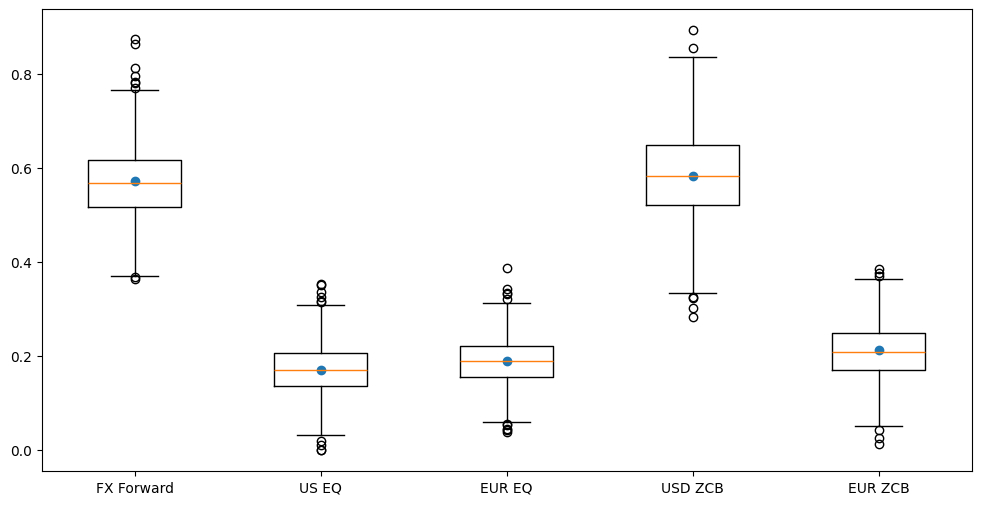

In [104]:
opt_sub_h_true = calculate_portfolio_w_subsequent_hedge(mu_p=mu_p_l, cov_mat_pnl=cov_mat_pnl, pnl_target=0.04)

fig, ax = plt.subplots(figsize=(12, 6))
ax.scatter(np.arange(1, 6), opt_sub_h_true)
ax.boxplot(sim_opt_sub_h, tick_labels=plot_names);

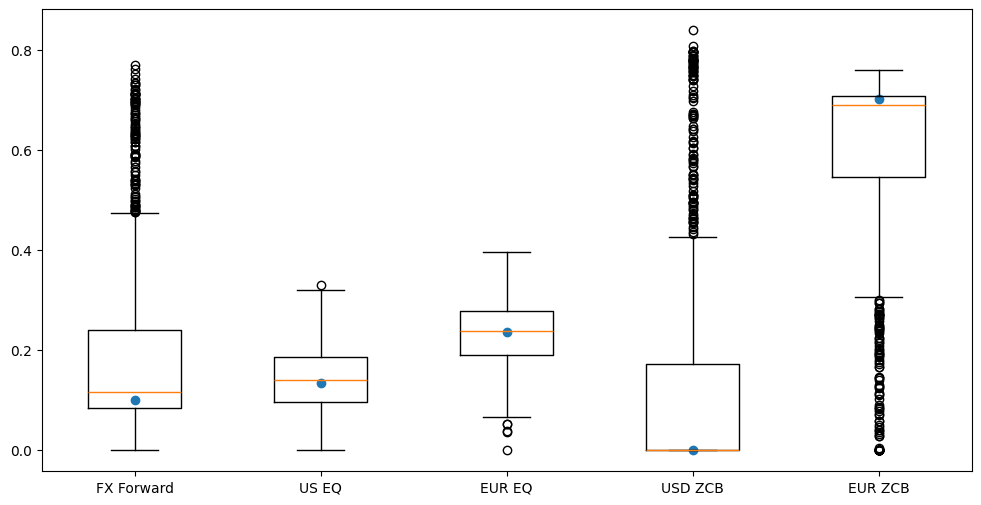

In [105]:
opt_pre_h_true = calculate_portfolio_prespecified(mu_p=mu_p_l, cov_mat_pnl=cov_mat_pnl, pnl_target=0.04)

fig, ax = plt.subplots(figsize=(12, 6))
ax.scatter(np.arange(1, 6), opt_pre_h_true)
ax.boxplot(sim_opt_pre_h, tick_labels=plot_names);

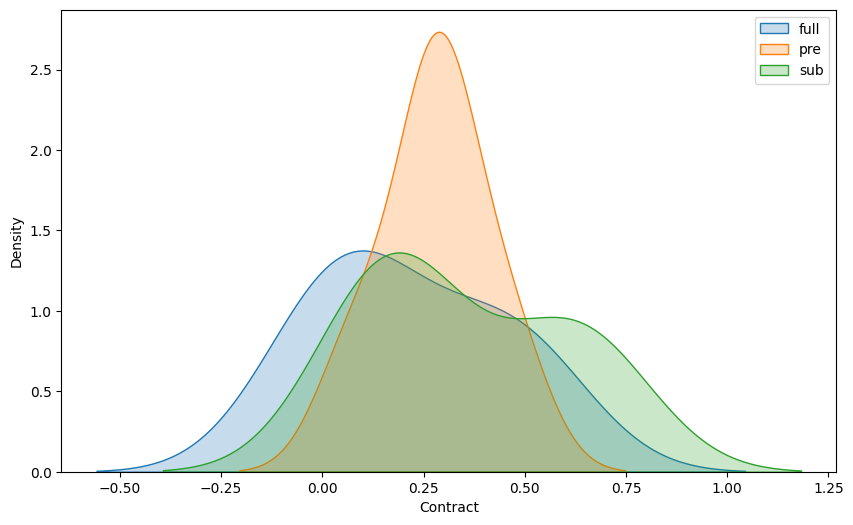

In [106]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.kdeplot(sim_opt_full_h[0], fill=True, label="full")
sns.kdeplot(sim_opt_pre_h[0], fill=True, label="pre")
sns.kdeplot(sim_opt_sub_h[0], fill=True, label="sub")

ax.legend()
ax.set_xlabel(xlabel="Contract");

In [107]:
"""
Calculate the corresponding distribution of mean PnL, variance and conditional value at risk  
"""

# full
sim_mu_full_pnl = sim_opt_full_h @ mu_pnl
sim_sigma2_full_pnl = np.apply_along_axis(lambda x: x @ cov_mat_pnl @ x, 1, sim_opt_full_h)
sim_sigma_full_pnl = np.sqrt(sim_sigma2_full_pnl)

sim_cvar_full_pnl = np.apply_along_axis(lambda x: -rm.calculate_conditional_value_at_risk(x @ final_pnl, 0.05), 1, sim_opt_full_h)

# sub
sim_mu_sub_pnl = sim_opt_sub_h @ mu_pnl
sim_sigma2_sub_pnl = np.apply_along_axis(lambda x: x @ cov_mat_pnl @ x, 1, sim_opt_sub_h)
sim_sigma_sub_pnl = np.sqrt(sim_sigma2_sub_pnl)

sim_cvar_sub_pnl = np.apply_along_axis(lambda x: -rm.calculate_conditional_value_at_risk(x @ final_pnl, 0.05), 1, sim_opt_sub_h)

# pre

sim_mu_pre_pnl = sim_opt_pre_h @ mu_pnl
sim_sigma2_pre_pnl = np.apply_along_axis(lambda x: x @ cov_mat_pnl @ x, 1, sim_opt_pre_h)
sim_sigma_pre_pnl = np.sqrt(sim_sigma2_pre_pnl)

sim_cvar_pre_pnl = np.apply_along_axis(lambda x: -rm.calculate_conditional_value_at_risk(x @ final_pnl, 0.05), 1, sim_opt_pre_h)

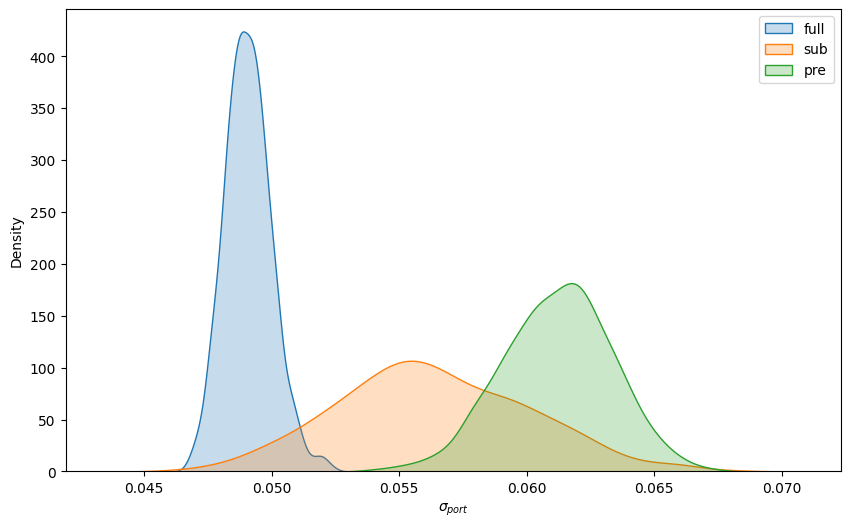

In [108]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.kdeplot(sim_sigma_full_pnl, fill=True, label="full")
sns.kdeplot(sim_sigma_sub_pnl, fill=True, label="sub")
sns.kdeplot(sim_sigma_pre_pnl, fill=True, label="pre")

ax.legend()
ax.set_xlabel(xlabel="$\sigma_{port}$");

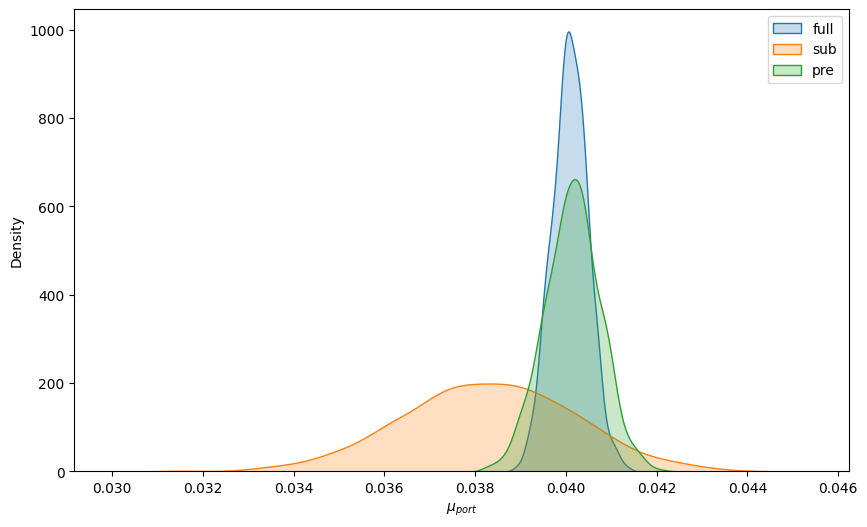

In [109]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.kdeplot(sim_mu_full_pnl, fill=True, label="full")
sns.kdeplot(sim_mu_sub_pnl, fill=True, label="sub")
sns.kdeplot(sim_mu_pre_pnl, fill=True, label="pre")

ax.legend()
ax.set_xlabel(xlabel="$\mu_{port}$");

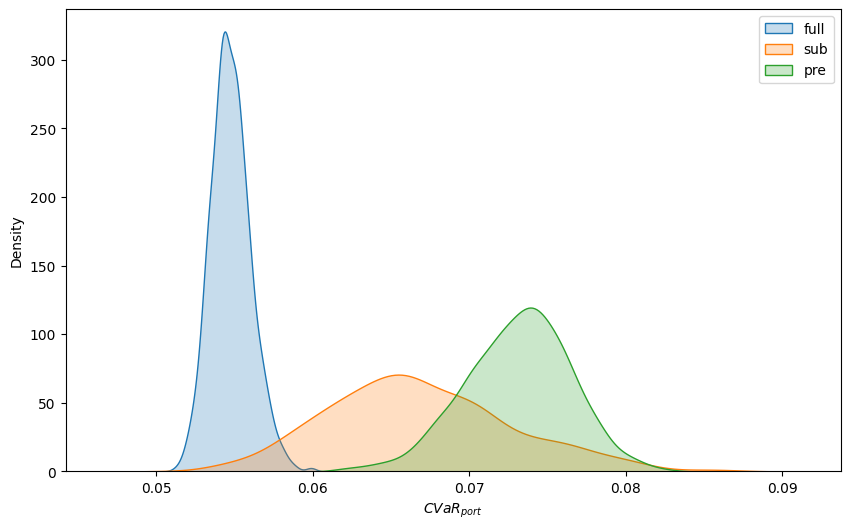

In [110]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.kdeplot(sim_cvar_full_pnl, fill=True, label="full")
sns.kdeplot(sim_cvar_sub_pnl, fill=True, label="sub")
sns.kdeplot(sim_cvar_pre_pnl, fill=True, label="pre")

ax.legend()
ax.set_xlabel(xlabel="$CVaR_{port}$");

## Estimation uncertainty and the minimum variance portfolio

### Pre-specified

In [111]:
def calculate_min_var_portfolio_prespecified(mu_p, cov_mat_pnl): 

    mu_pnl = mu_p - init_p
    mu_pnl[0] = 1 / fwd_price - mu_pnl[0]
    
    """
    Define problem for optimization
    """
    
    # define optimization variable
    h = cp.Variable(5)

    hr_us_eq = calculate_min_var_hedge_ratio(cov_mat_pnl, np.array([1 / init_p[us_eq_idx], 0, 0, 0]))
    hr_usd_zcb = calculate_min_var_hedge_ratio(cov_mat_pnl, np.array([0, 0, 1 / init_p[usd_zcb_idx], 0]))

    #print(hr_us_eq)
    #print(hr_usd_zcb)
    
    # define constraints 
    constraints = []
    constraints.append(h[0] == h[1] * hr_us_eq *  init_p[1] * init_fx  + h[3] * hr_usd_zcb *  init_p[3] * init_fx)
    constraints.append(h @ init_p == 1)
    constraints.append(h[1:] >= 0)
    constraints.append(h[0] <= 2 * init_fx)
    constraints.append(h[0] >= -2 * init_fx)
    
    # define objective 
    port_var = cp.Minimize(cp.QuadForm(h, cov_mat_pnl))
    
    # define problem 
    problem = cp.Problem(objective=port_var, constraints=constraints)
    
    # solve problem 
    result = problem.solve()
    #print(h.value)
    return np.array(h.value)

In [112]:
sim_min_var_opt_pre_h = np.array([calculate_min_var_portfolio_prespecified(mu_p=sim_mu_l[i], cov_mat_pnl=sim_cov_mat_pnl[i]) for i in range(1000)])

### subsequent

In [113]:
def calculate_min_var_portfolio_w_subsequent_hedge(mu_p, cov_mat_pnl): 

    mu_pnl = mu_p - init_p
    mu_pnl[0] = 1 / fwd_price - mu_pnl[0]

    """
    Define problem for optimization
    """
    
    # define optimization variable
    h = cp.Variable(5)
    
    # define constraints 
    constraints = []
    constraints.append(h @ init_p == 1)
    constraints.append(h[1:] >= 0)
    constraints.append(h[0] == 0)
    
    # define objective 
    port_var = cp.Minimize(cp.QuadForm(h, cov_mat_pnl))
    
    # define problem 
    problem = cp.Problem(objective=port_var, constraints=constraints)
    
    # solve problem 
    result = problem.solve()

    # subsequent minimum-variance hedge 
    h_opt = np.array(h.value)
    opt_hr = calculate_min_var_hedge_ratio(cov_mat_pnl, h_opt[1:])
    h_opt[0] = opt_hr

    return h_opt

In [114]:
sim_min_var_opt_sub_h = np.array([calculate_min_var_portfolio_w_subsequent_hedge(mu_p=sim_mu_l[i],
                                                                 cov_mat_pnl=sim_cov_mat_pnl[i]) for i in range(1000)])

### Full

In [115]:
def calculate_min_var_portfolio_full(mu_p, cov_mat_pnl): 

    mu_pnl = mu_p - init_p
    mu_pnl[0] = 1 / fwd_price - mu_pnl[0]
    
    """
    Define problem for optimization
    """
    
    h = cp.Variable(5)
    
    # define constraints 
    constraints = []
    constraints.append(h @ init_p == 1)
    constraints.append(h[1:] >= 0)
    constraints.append(h[0] <= 2 * init_fx)
    constraints.append(h[0] >= -2 * init_fx)
    
    # define objective 
    port_var = cp.Minimize(cp.QuadForm(h, cov_mat_pnl))
    
    # define problem 
    problem = cp.Problem(objective=port_var, constraints=constraints)
    
    # solve problem 
    result = problem.solve()

    return np.array(h.value)

In [116]:
sim_min_var_opt_full_h = np.array([calculate_min_var_portfolio_full(mu_p=sim_mu_l[i], cov_mat_pnl=sim_cov_mat_pnl[i]) for i in range(1000)])

In [117]:
sim_min_var_opt_full_h.shape

(1000, 5)

### Comparison

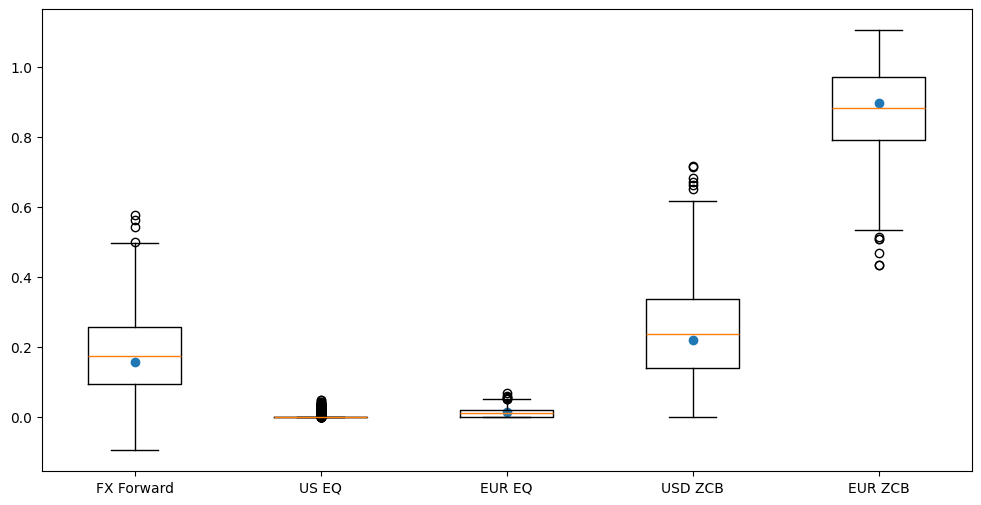

In [118]:
opt_min_var_full_h_true = calculate_min_var_portfolio_full(mu_p=mu_p_l, cov_mat_pnl=cov_mat_pnl)

fig, ax = plt.subplots(figsize=(12, 6))
ax.scatter(np.arange(1, 6), opt_min_var_full_h_true)
ax.boxplot(sim_min_var_opt_full_h, tick_labels=plot_names);

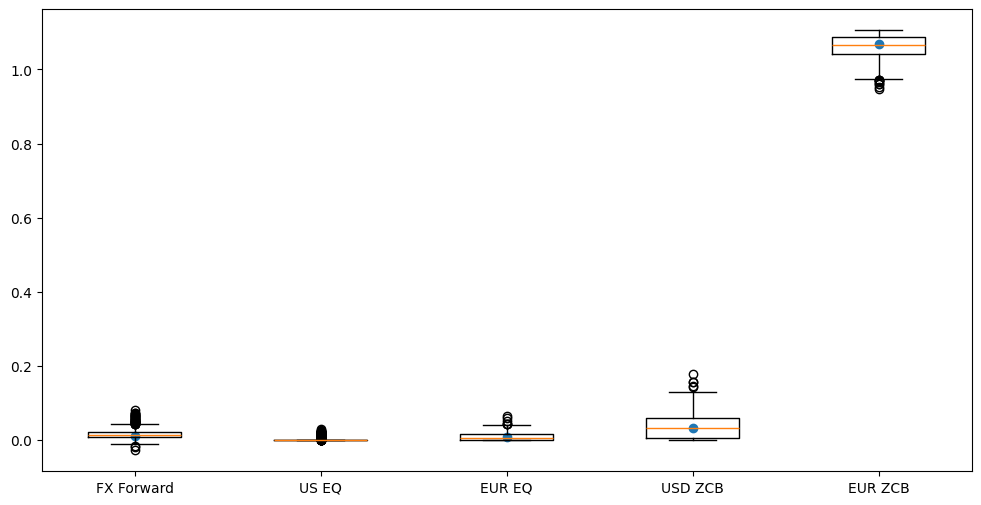

In [119]:
opt_min_var_sub_h_true = calculate_min_var_portfolio_w_subsequent_hedge(mu_p=mu_p_l, cov_mat_pnl=cov_mat_pnl)

fig, ax = plt.subplots(figsize=(12, 6))
ax.scatter(np.arange(1, 6), opt_min_var_sub_h_true)
ax.boxplot(sim_min_var_opt_sub_h, tick_labels=plot_names);

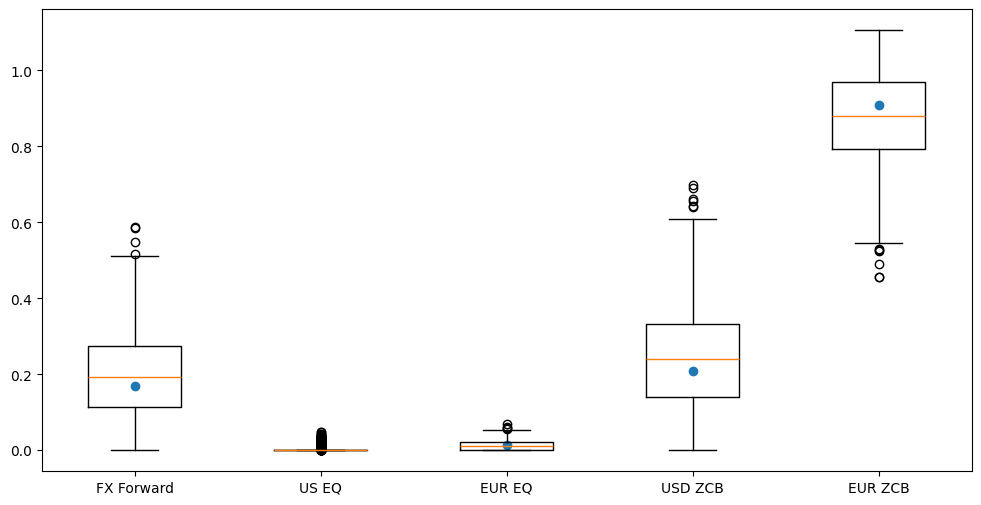

In [120]:
opt_min_var_pre_h_true = calculate_min_var_portfolio_prespecified(mu_p=mu_p_l, cov_mat_pnl=cov_mat_pnl)

fig, ax = plt.subplots(figsize=(12, 6))
ax.scatter(np.arange(1, 6), opt_min_var_pre_h_true)
ax.boxplot(sim_min_var_opt_pre_h, tick_labels=plot_names);

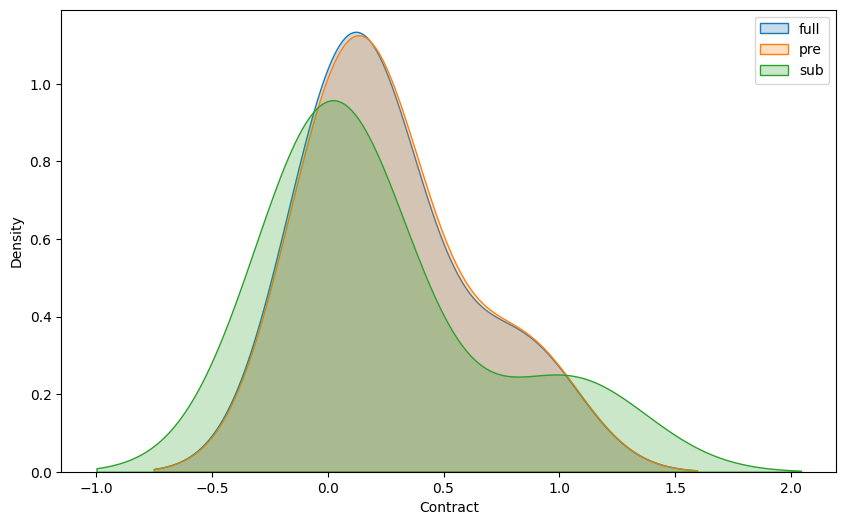

In [121]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.kdeplot(sim_min_var_opt_full_h[0], fill=True, label="full")
sns.kdeplot(sim_min_var_opt_pre_h[0], fill=True, label="pre")
sns.kdeplot(sim_min_var_opt_sub_h[0], fill=True, label="sub")

ax.legend()
ax.set_xlabel(xlabel="Contract");

In [122]:
"""
Calculate the corresponding distribution of mean PnL, variance and conditional value at risk  
"""

# full
sim_mu_full_pnl = sim_min_var_opt_full_h @ mu_pnl
sim_sigma2_full_pnl = np.apply_along_axis(lambda x: x @ cov_mat_pnl @ x, 1, sim_min_var_opt_full_h)
sim_sigma_full_pnl = np.sqrt(sim_sigma2_full_pnl)

sim_cvar_full_pnl = np.apply_along_axis(lambda x: -rm.calculate_conditional_value_at_risk(x @ final_pnl, 0.05), 1, sim_min_var_opt_full_h)

# sub
sim_mu_sub_pnl = sim_min_var_opt_sub_h @ mu_pnl
sim_sigma2_sub_pnl = np.apply_along_axis(lambda x: x @ cov_mat_pnl @ x, 1, sim_min_var_opt_sub_h)
sim_sigma_sub_pnl = np.sqrt(sim_sigma2_sub_pnl)

sim_cvar_sub_pnl = np.apply_along_axis(lambda x: -rm.calculate_conditional_value_at_risk(x @ final_pnl, 0.05), 1, sim_min_var_opt_sub_h)

# pre

sim_mu_pre_pnl = sim_min_var_opt_pre_h @ mu_pnl
sim_sigma2_pre_pnl = np.apply_along_axis(lambda x: x @ cov_mat_pnl @ x, 1, sim_min_var_opt_pre_h)
sim_sigma_pre_pnl = np.sqrt(sim_sigma2_pre_pnl)

sim_cvar_pre_pnl = np.apply_along_axis(lambda x: -rm.calculate_conditional_value_at_risk(x @ final_pnl, 0.05), 1, sim_min_var_opt_pre_h)

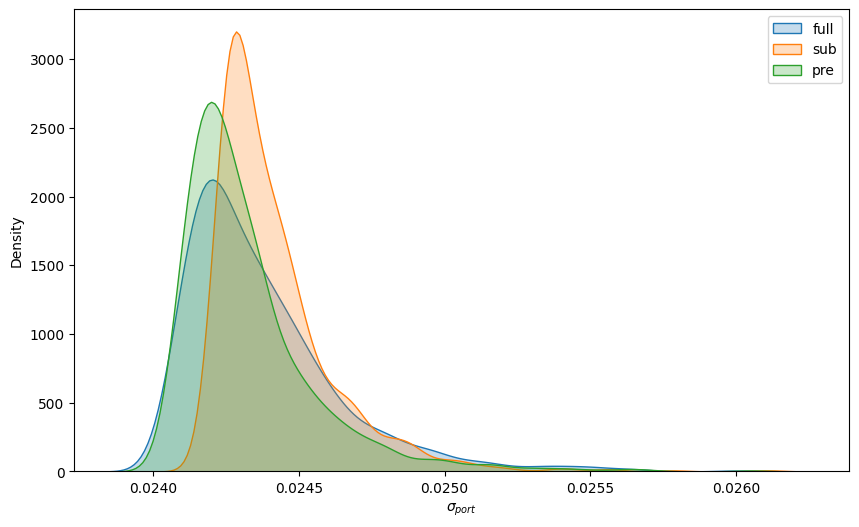

In [123]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.kdeplot(sim_sigma_full_pnl, fill=True, label="full")
sns.kdeplot(sim_sigma_sub_pnl, fill=True, label="sub")
sns.kdeplot(sim_sigma_pre_pnl, fill=True, label="pre")

ax.legend()
ax.set_xlabel(xlabel="$\sigma_{port}$");

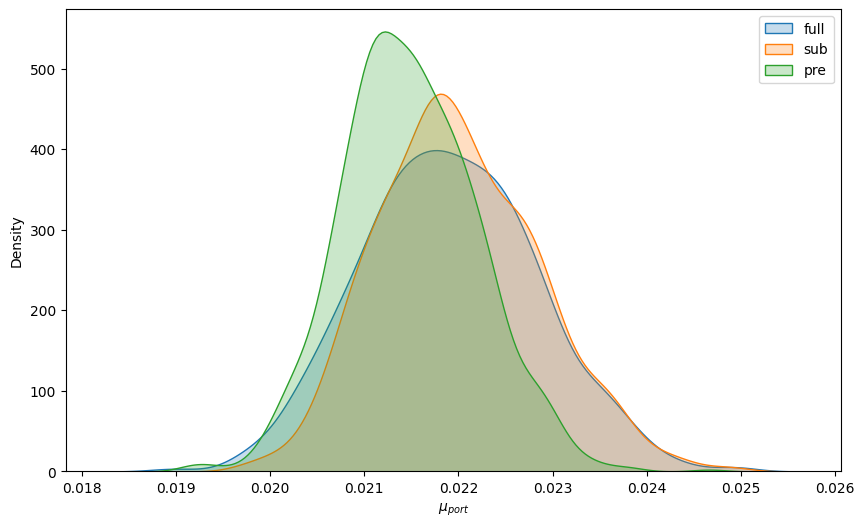

In [124]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.kdeplot(sim_mu_full_pnl, fill=True, label="full")
sns.kdeplot(sim_mu_sub_pnl, fill=True, label="sub")
sns.kdeplot(sim_mu_pre_pnl, fill=True, label="pre")

ax.legend()
ax.set_xlabel(xlabel="$\mu_{port}$");

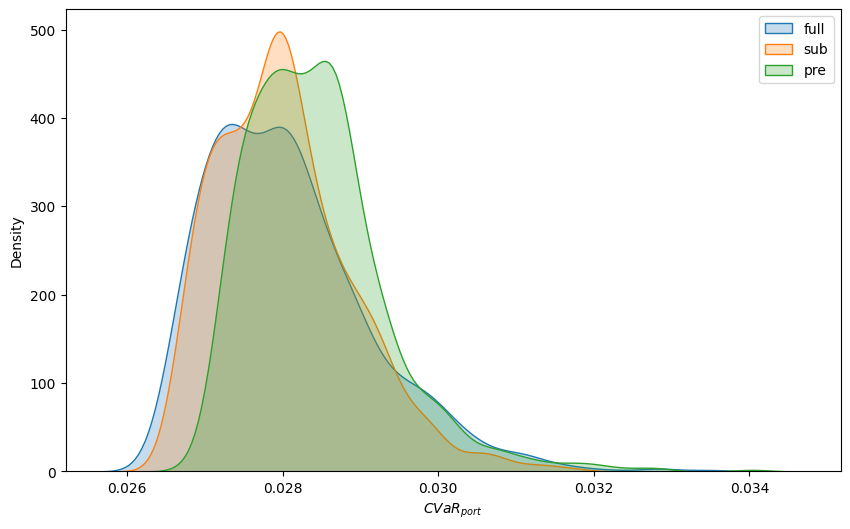

In [125]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.kdeplot(sim_cvar_full_pnl, fill=True, label="full")
sns.kdeplot(sim_cvar_sub_pnl, fill=True, label="sub")
sns.kdeplot(sim_cvar_pre_pnl, fill=True, label="pre")

ax.legend()
ax.set_xlabel(xlabel="$CVaR_{port}$");